# Halofit Emulation
Author: João Victor Rebouças, May 2023

In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import keras
import euclidemu2 as ee2
import train_utils as utils
from train_utils import params, lims, ref
# Don't worry about tensorflow warnings

2023-06-28 12:26:23.628076: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 12:26:23.653982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Train redshifts
redshifts = [z for z in utils.redshifts if z <= 3]

### Data preprocessing
**How to use**: select the desired dataset in `path_to_train` and run all subsequent cells until the [training section](#Training).

**Pipeline description**:
- Load chosen training data
- Smear BAO in linear $P(k)$ (using BACCO's code)
- Calculate $Q(k) = \log(P_\mathrm{NL}/P_\mathrm{lin,\, smear})$
- Normalize cosmological parameters based on EE2 box boundaries
- Normalize $Q$ using min-max
- Save $Q$ normalization parameters (for rescaling $Q$ after emulation)
- PCA

In [3]:
# Data can be downloaded at https://github.com/SBU-Jonathan/halofit_data
# LCDM datasets
path_to_spectra = "/home/grads/data/jonathan/cola_projects/COLA_output/"
path_to_train_lcdm = path_to_spectra + "LCDM/400_1"

# wCDM datasets
path_to_train_wcdm = path_to_spectra + "WCDM/500_1"

In [4]:
# Select which training dataset to use
path_to_train = path_to_train_lcdm
ks = utils.ks_cola_default

In [5]:
# Load training LHS
path_to_lcdm_lhs = "/home/grads/data/jonathan/cola_projects/COLA_input/LCDM/400_1/lhs.txt"
train_samples = np.loadtxt(path_to_lcdm_lhs)
print(train_samples[0])

[2.98998249e-01 5.84627549e-02 9.66097472e-01 1.99213595e-09
 6.75717014e-01]


In [13]:
# Load ref cosmology from CAMB, all redshifts
pk_lin_ref = np.zeros((len(redshifts), len(ks)))
pk_nl_a_ref = np.zeros((len(redshifts), len(ks)))
pk_nl_b_ref = np.zeros((len(redshifts), len(ks)))
pk_lin_smear_ref = np.zeros((len(redshifts), len(ks)))
for i, redshift in enumerate(redshifts):
    pk_nl_a_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/a/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
    pk_nl_b_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/b/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
    pk_lin_smear_ref[i] = utils.smear_bao(ks, pk_lin_ref[i], utils.smooth_bao(ks, pk_lin_ref[i]), par=0.5)
pk_nl_ref = (pk_nl_a_ref + pk_nl_b_ref)/2

/tmp/ipykernel_865695/2152983183.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/a/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(utils.ks_cola_default), usecols=(1,2))
/tmp/ipykernel_865695/2152983183.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.

In [14]:
ref_params = {
    "h": 0.67,
    "Omm": 0.319,
    "Omb": 0.049,
    "As": 2.1e-9,
    "ns": 0.96,
    "w": -1,
    "wa": 0,
    "mnu": 0.058
}
ks, boost_ref_ee2 = ee2.get_boost(ref_params, redshifts, ks)
expq_ref_ee2 = np.zeros((len(redshifts), len(ks)))
for i, z in enumerate(redshifts):
    expq_ref_ee2[i] = boost_ref_ee2[i] * pk_lin_ref[i] / pk_lin_smear_ref[i]

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.


In [18]:
# Load training data, takes several minutes
pks_lin_train = np.zeros((len(train_samples), len(redshifts), len(ks)))
pks_lin_smear_train = np.zeros((len(train_samples), len(redshifts), len(ks)))
pks_nl_train = np.zeros((len(train_samples), len(redshifts), len(ks)))

for i in range(len(train_samples)):
    for j, redshift in enumerate(redshifts):
        pk_nl_a_train, pks_lin_train[i,j],  = np.loadtxt(f"{path_to_train}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
        pk_nl_b_train, pks_lin_train[i,j] = np.loadtxt(f"{path_to_train}/b/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
        pks_nl_train[i,j] = (pk_nl_a_train + pk_nl_b_train)/2
        try:
            pks_lin_smear_train[i,j] = utils.smear_bao(ks, pks_lin_train[i,j], utils.smooth_bao(ks, pks_lin_train[i,j]))
        except Exception as err:
            print(f"Cannot smear pk in cosmology {i} at redshift {redshift}: {err}")

/tmp/ipykernel_865695/3158739856.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a_train, pks_lin_train[i,j],  = np.loadtxt(f"{path_to_train}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(utils.ks_cola_default), usecols=(1,2))
/tmp/ipykernel_865695/3158739856.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `

In [19]:
# Subtracting shot noise
pk_nl_ref -= 1
pks_nl_train -= 1

In [20]:
# Defining emulated quantities
train_logboosts = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i in range(len(train_samples)):
    r_nl = pks_nl_train[i]/pk_nl_ref
    r_lin = pks_lin_train[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_train[i]/pk_lin_smear_ref
    for j in range(len(redshifts)):
        train_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
        train_qs[i,j] = np.log(expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j])

/tmp/ipykernel_865695/897578998.py:9: RuntimeWarning: invalid value encountered in log
  train_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
/tmp/ipykernel_865695/897578998.py:10: RuntimeWarning: invalid value encountered in log
  train_qs[i,j] = np.log(expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j])


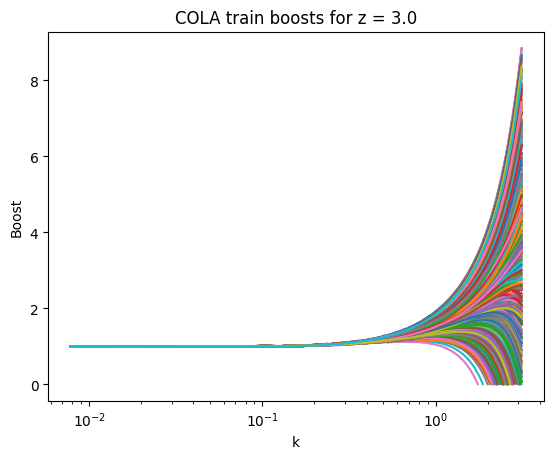

In [102]:
z_index = 39
for i in range(400):
    plt.semilogx(ks, np.exp(train_logboosts[i,z_index]))
plt.title(f"COLA train boosts for z = {redshifts[z_index]}")
plt.xlabel("k")
plt.ylabel("Boost");

In [38]:
# Normalized parameters - input for NN
train_sample_norm = np.zeros((len(train_samples), len(train_samples[0])))
for i, train_point in enumerate(train_samples):
    train_sample_norm[i] = utils.normalize_params(train_point)

In [43]:
# Normalized Boosts with Min-Max
train_logboosts_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i in range(len(redshifts)):
    train_logboosts_norm[:,i,:] = utils.normalize_array(train_logboosts[:,i,:]) # I normalize within each redshift
    train_qs_norm[:,i,:] = utils.normalize_array(train_qs[:,i,:]) # I normalize within each redshift

In [44]:
# Getting and saving min and max for rescaling
mins_logboosts = np.zeros(len(redshifts))
maxs_logboosts = np.zeros(len(redshifts))
mins_qs = np.zeros(len(redshifts))
maxs_qs = np.zeros(len(redshifts))

for i in range(len(redshifts)):
    mins_logboosts[i] = np.amin(train_logboosts[:,i,:])
    maxs_logboosts[i] = np.amax(train_logboosts[:,i,:])
    mins_qs[i] = np.amin(train_qs[:,i,:])
    maxs_qs[i] = np.amax(train_qs[:,i,:])

In [84]:
# PCA reduction
num_pcs = 11
# pcas_logboosts, train_logboosts_pcs = utils.pca_reduction(num_pcs, train_logboosts_norm, redshifts)
pcas_qs, train_qs_pcs = utils.pca_reduction(num_pcs, train_qs_norm, redshifts[:35])

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [98]:
np.isnan(train_logboosts[:,34,:]).any()

True

### Training
**How to use**: 
- **Must have run [data preprocessing](#Data-preprocessing) section with the desired dataset**
- Define your model using the `utils.generate_resnet` or `utils.generate_mlp` functions.
- Train the model using the `utils.nn_model_train` function, where you can choose to train on `logboosts` or smeared boosts.
- Save your model using `model.save("path")`.
- See cells below for examples on training individual models at $z = 0$ and how to sequentially train models on all redshifts.

In [51]:
# Generate MLP model
mlp = utils.generate_mlp(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_layers=3,
    num_neurons=512,
    activation="custom",
    alpha=0,
    l1_ratio=0.1,
    loss='mse',
    learning_rate=1e-3,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 512)               3072      
                                                                 
 custom_activation_layer (Cu  (None, 512)              1024      
 stomActivationLayer)                                            
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_1 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               262656

In [16]:
# Generate resnet model
resnet = utils.generate_resnet(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_res_blocks=1,
    num_of_neurons=1024,
    activation="relu",
    alpha=0,
    l1_ratio=0.1,
    dropout=0
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 1024)         6144        ['input_2[0][0]']                
                                                                                                  
 custom_activation_layer_3 (Cus  (None, 1024)        2048        ['dense_4[0][0]']                
 tomActivationLayer)                                                                              
                                                                                                  
 dense_5 (Dense)                (None, 1024)         1049600     ['custom_activation_layer_3

In [52]:
# Training (z=0) for 2.6k epochs. Starting from epoch 1500, the learning rate halves every 200 epochs
start = perf_counter()
last_loss = utils.nn_model_train(mlp, 1600, train_sample_norm, train_qs_pcs[:,0], decayevery=1500, decayrate=2)
last_loss = utils.nn_model_train(mlp, 1000, train_sample_norm, train_qs_pcs[:,0], decayevery=200, decayrate=2)
print(f"Training took {perf_counter() - start} seconds")

Epoch 1/1600
14/14 [==============================] - 1s 6ms/step - loss: 0.0262 - lr: 0.0010
Epoch 2/1600
14/14 [==============================] - 0s 6ms/step - loss: 0.0099 - lr: 0.0010
Epoch 3/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061 - lr: 0.0010
Epoch 4/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 5/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 6/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 7/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 8/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 9/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 10/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 11/1600
14/14 [==============================] - 0s 5

Epoch 86/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9676e-04 - lr: 0.0010
Epoch 87/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9062e-04 - lr: 0.0010
Epoch 88/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1656e-04 - lr: 0.0010
Epoch 89/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6686e-04 - lr: 0.0010
Epoch 90/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.8846e-04 - lr: 0.0010
Epoch 91/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.0639e-04 - lr: 0.0010
Epoch 92/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.6259e-04 - lr: 0.0010
Epoch 93/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4420e-04 - lr: 0.0010
Epoch 94/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3916e-04 - lr: 0.0010
Epoch 95/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4745e-04 - lr: 0.0010
Epoch 96/1

14/14 [==============================] - 0s 5ms/step - loss: 4.9974e-05 - lr: 0.0010
Epoch 169/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.7060e-05 - lr: 0.0010
Epoch 170/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.6538e-05 - lr: 0.0010
Epoch 171/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.4236e-05 - lr: 0.0010
Epoch 172/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.3298e-05 - lr: 0.0010
Epoch 173/1600
14/14 [==============================] - 0s 4ms/step - loss: 4.4220e-05 - lr: 0.0010
Epoch 174/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.7968e-05 - lr: 0.0010
Epoch 175/1600
14/14 [==============================] - 0s 7ms/step - loss: 3.5783e-05 - lr: 0.0010
Epoch 176/1600
14/14 [==============================] - 0s 6ms/step - loss: 4.6648e-05 - lr: 0.0010
Epoch 177/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.9561e-05 - lr: 0.0010
Epoch 178/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.8160e-05 - lr: 0.0010
Epoch 251/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1217e-05 - lr: 0.0010
Epoch 252/1600
14/14 [==============================] - 0s 4ms/step - loss: 2.0821e-05 - lr: 0.0010
Epoch 253/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4192e-05 - lr: 0.0010
Epoch 254/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7522e-05 - lr: 0.0010
Epoch 255/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.3662e-05 - lr: 0.0010
Epoch 256/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1092e-05 - lr: 0.0010
Epoch 257/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.2251e-05 - lr: 0.0010
Epoch 258/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1745e-05 - lr: 0.0010
Epoch 259/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7072e-05 - lr: 0.0010
Epoch 260/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.4610e-05 - lr: 0.0010
Epoch 333/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1087e-05 - lr: 0.0010
Epoch 334/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0972e-05 - lr: 0.0010
Epoch 335/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3011e-05 - lr: 0.0010
Epoch 336/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3205e-05 - lr: 0.0010
Epoch 337/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7854e-05 - lr: 0.0010
Epoch 338/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.6356e-05 - lr: 0.0010
Epoch 339/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.9738e-05 - lr: 0.0010
Epoch 340/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7845e-05 - lr: 0.0010
Epoch 341/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9256e-05 - lr: 0.0010
Epoch 342/1600


14/14 [==============================] - 0s 5ms/step - loss: 5.6149e-05 - lr: 0.0010
Epoch 415/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.8080e-05 - lr: 0.0010
Epoch 416/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.8366e-05 - lr: 0.0010
Epoch 417/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7232e-05 - lr: 0.0010
Epoch 418/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5502e-05 - lr: 0.0010
Epoch 419/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.6671e-05 - lr: 0.0010
Epoch 420/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4762e-05 - lr: 0.0010
Epoch 421/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2099e-05 - lr: 0.0010
Epoch 422/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3069e-05 - lr: 0.0010
Epoch 423/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.7226e-06 - lr: 0.0010
Epoch 424/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0775e-05 - lr: 0.0010
Epoch 497/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3628e-05 - lr: 0.0010
Epoch 498/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3313e-05 - lr: 0.0010
Epoch 499/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.4327e-04 - lr: 0.0010
Epoch 500/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.1077e-05 - lr: 0.0010
Epoch 501/1600
14/14 [==============================] - 0s 3ms/step - loss: 3.1417e-05 - lr: 0.0010
Epoch 502/1600
14/14 [==============================] - 0s 3ms/step - loss: 1.4253e-05 - lr: 0.0010
Epoch 503/1600
14/14 [==============================] - 0s 3ms/step - loss: 2.3238e-05 - lr: 0.0010
Epoch 504/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9862e-05 - lr: 0.0010
Epoch 505/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.5542e-05 - lr: 0.0010
Epoch 506/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.3944e-05 - lr: 0.0010
Epoch 579/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9915e-05 - lr: 0.0010
Epoch 580/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.4707e-05 - lr: 0.0010
Epoch 581/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.2539e-05 - lr: 0.0010
Epoch 582/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1671e-06 - lr: 0.0010
Epoch 583/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.0366e-06 - lr: 0.0010
Epoch 584/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.2382e-06 - lr: 0.0010
Epoch 585/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0316e-06 - lr: 0.0010
Epoch 586/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0686e-06 - lr: 0.0010
Epoch 587/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0423e-05 - lr: 0.0010
Epoch 588/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0476e-05 - lr: 0.0010
Epoch 661/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6659e-05 - lr: 0.0010
Epoch 662/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7769e-05 - lr: 0.0010
Epoch 663/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4978e-05 - lr: 0.0010
Epoch 664/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.3835e-05 - lr: 0.0010
Epoch 665/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6592e-05 - lr: 0.0010
Epoch 666/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7180e-05 - lr: 0.0010
Epoch 667/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.6108e-06 - lr: 0.0010
Epoch 668/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.5575e-06 - lr: 0.0010
Epoch 669/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3466e-05 - lr: 0.0010
Epoch 670/1600


14/14 [==============================] - 0s 5ms/step - loss: 6.6898e-05 - lr: 0.0010
Epoch 743/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.8431e-05 - lr: 0.0010
Epoch 744/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0516e-05 - lr: 0.0010
Epoch 745/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8084e-05 - lr: 0.0010
Epoch 746/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7679e-05 - lr: 0.0010
Epoch 747/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2700e-05 - lr: 0.0010
Epoch 748/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1225e-06 - lr: 0.0010
Epoch 749/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.5875e-06 - lr: 0.0010
Epoch 750/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0041e-05 - lr: 0.0010
Epoch 751/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.5791e-05 - lr: 0.0010
Epoch 752/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.5115e-04 - lr: 0.0010
Epoch 825/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0157e-04 - lr: 0.0010
Epoch 826/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.4923e-05 - lr: 0.0010
Epoch 827/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2992e-05 - lr: 0.0010
Epoch 828/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4221e-05 - lr: 0.0010
Epoch 829/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6232e-05 - lr: 0.0010
Epoch 830/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.2247e-05 - lr: 0.0010
Epoch 831/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3030e-05 - lr: 0.0010
Epoch 832/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6970e-05 - lr: 0.0010
Epoch 833/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0105e-05 - lr: 0.0010
Epoch 834/1600


14/14 [==============================] - 0s 5ms/step - loss: 8.6997e-06 - lr: 0.0010
Epoch 907/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0552e-05 - lr: 0.0010
Epoch 908/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3109e-05 - lr: 0.0010
Epoch 909/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.3307e-05 - lr: 0.0010
Epoch 910/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.7847e-05 - lr: 0.0010
Epoch 911/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7746e-05 - lr: 0.0010
Epoch 912/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4205e-05 - lr: 0.0010
Epoch 913/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0398e-05 - lr: 0.0010
Epoch 914/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.2948e-06 - lr: 0.0010
Epoch 915/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.3448e-06 - lr: 0.0010
Epoch 916/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0309e-05 - lr: 0.0010
Epoch 989/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5785e-06 - lr: 0.0010
Epoch 990/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.7946e-06 - lr: 0.0010
Epoch 991/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0580e-05 - lr: 0.0010
Epoch 992/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1895e-06 - lr: 0.0010
Epoch 993/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.9880e-06 - lr: 0.0010
Epoch 994/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.3072e-06 - lr: 0.0010
Epoch 995/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3460e-05 - lr: 0.0010
Epoch 996/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7790e-05 - lr: 0.0010
Epoch 997/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2937e-05 - lr: 0.0010
Epoch 998/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.5654e-05 - lr: 0.0010
Epoch 1070/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0078e-06 - lr: 0.0010
Epoch 1071/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.9605e-06 - lr: 0.0010
Epoch 1072/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.5571e-06 - lr: 0.0010
Epoch 1073/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.0011e-05 - lr: 0.0010
Epoch 1074/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.2947e-06 - lr: 0.0010
Epoch 1075/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.1758e-06 - lr: 0.0010
Epoch 1076/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.0241e-06 - lr: 0.0010
Epoch 1077/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.2015e-06 - lr: 0.0010
Epoch 1078/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.2265e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5155e-05 - lr: 0.0010
Epoch 1151/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9665e-05 - lr: 0.0010
Epoch 1152/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5370e-05 - lr: 0.0010
Epoch 1153/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1769e-05 - lr: 0.0010
Epoch 1154/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.9986e-06 - lr: 0.0010
Epoch 1155/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2400e-05 - lr: 0.0010
Epoch 1156/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.9192e-06 - lr: 0.0010
Epoch 1157/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5103e-06 - lr: 0.0010
Epoch 1158/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6910e-05 - lr: 0.0010
Epoch 1159/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.7146e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5554e-05 - lr: 0.0010
Epoch 1232/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2751e-05 - lr: 0.0010
Epoch 1233/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.6142e-05 - lr: 0.0010
Epoch 1234/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.6374e-05 - lr: 0.0010
Epoch 1235/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.5196e-05 - lr: 0.0010
Epoch 1236/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2233e-05 - lr: 0.0010
Epoch 1237/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7256e-05 - lr: 0.0010
Epoch 1238/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.8310e-06 - lr: 0.0010
Epoch 1239/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.1278e-06 - lr: 0.0010
Epoch 1240/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.3743e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.9035e-06 - lr: 0.0010
Epoch 1313/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5104e-06 - lr: 0.0010
Epoch 1314/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5215e-06 - lr: 0.0010
Epoch 1315/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.6864e-06 - lr: 0.0010
Epoch 1316/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0683e-06 - lr: 0.0010
Epoch 1317/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0355e-06 - lr: 0.0010
Epoch 1318/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1849e-05 - lr: 0.0010
Epoch 1319/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5020e-06 - lr: 0.0010
Epoch 1320/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0275e-05 - lr: 0.0010
Epoch 1321/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.1576e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.4456e-06 - lr: 0.0010
Epoch 1394/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5796e-06 - lr: 0.0010
Epoch 1395/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.8586e-06 - lr: 0.0010
Epoch 1396/1600
14/14 [==============================] - 0s 6ms/step - loss: 4.2211e-06 - lr: 0.0010
Epoch 1397/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3285e-06 - lr: 0.0010
Epoch 1398/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.0650e-06 - lr: 0.0010
Epoch 1399/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.0044e-06 - lr: 0.0010
Epoch 1400/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5168e-06 - lr: 0.0010
Epoch 1401/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.3374e-06 - lr: 0.0010
Epoch 1402/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0488e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.2183e-06 - lr: 0.0010
Epoch 1475/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8082e-05 - lr: 0.0010
Epoch 1476/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1941e-05 - lr: 0.0010
Epoch 1477/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0460e-05 - lr: 0.0010
Epoch 1478/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9784e-05 - lr: 0.0010
Epoch 1479/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.6908e-05 - lr: 0.0010
Epoch 1480/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6609e-05 - lr: 0.0010
Epoch 1481/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6716e-05 - lr: 0.0010
Epoch 1482/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.4024e-06 - lr: 0.0010
Epoch 1483/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5606e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.1672e-06 - lr: 5.0000e-04
Epoch 1554/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.4419e-06 - lr: 5.0000e-04
Epoch 1555/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3236e-06 - lr: 5.0000e-04
Epoch 1556/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3626e-06 - lr: 5.0000e-04
Epoch 1557/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8911e-06 - lr: 5.0000e-04
Epoch 1558/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.5085e-06 - lr: 5.0000e-04
Epoch 1559/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.5687e-06 - lr: 5.0000e-04
Epoch 1560/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2364e-06 - lr: 5.0000e-04
Epoch 1561/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.5381e-06 - lr: 5.0000e-04
Epoch 1562/1600
14/14 [==============================] - 0s 5ms/step - 

Epoch 32/1000
14/14 [==============================] - 0s 3ms/step - loss: 3.1606e-06 - lr: 5.0000e-04
Epoch 33/1000
14/14 [==============================] - 0s 3ms/step - loss: 4.2328e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 3ms/step - loss: 3.7396e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 3ms/step - loss: 2.8366e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4075e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0355e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3004e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6099e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8675e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 4.6785e-06 - lr: 5.0000e-04
Epoch 112/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8235e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8230e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6266e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5652e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.4660e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6761e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1361e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3918e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1

Epoch 190/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9757e-06 - lr: 5.0000e-04
Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8810e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6777e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0286e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8966e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.4543e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8436e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0918e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9630e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 2.1107e-06 - lr: 2.5000e-04
Epoch 269/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7227e-06 - lr: 2.5000e-04
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2263e-06 - lr: 2.5000e-04
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0256e-06 - lr: 2.5000e-04
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0432e-06 - lr: 2.5000e-04
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9662e-06 - lr: 2.5000e-04
Epoch 274/1000
14/14 [==============================] - 0s 6ms/step - loss: 2.4197e-06 - lr: 2.5000e-04
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5346e-06 - lr: 2.5000e-04
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2151e-06 - lr: 2.5000e-04
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0

Epoch 347/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1725e-06 - lr: 2.5000e-04
Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1770e-06 - lr: 2.5000e-04
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1762e-06 - lr: 2.5000e-04
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8347e-06 - lr: 2.5000e-04
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0694e-06 - lr: 2.5000e-04
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4422e-06 - lr: 2.5000e-04
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4666e-06 - lr: 2.5000e-04
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0618e-06 - lr: 2.5000e-04
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9657e-06 - lr: 2.5000e-04
Epoch 356/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 2.0358e-06 - lr: 1.2500e-04
Epoch 426/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6897e-06 - lr: 1.2500e-04
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5682e-06 - lr: 1.2500e-04
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8123e-06 - lr: 1.2500e-04
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6289e-06 - lr: 1.2500e-04
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7243e-06 - lr: 1.2500e-04
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6536e-06 - lr: 1.2500e-04
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6503e-06 - lr: 1.2500e-04
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5798e-06 - lr: 1.2500e-04
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7

Epoch 504/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8715e-06 - lr: 1.2500e-04
Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7313e-06 - lr: 1.2500e-04
Epoch 506/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.6211e-06 - lr: 1.2500e-04
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6776e-06 - lr: 1.2500e-04
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6461e-06 - lr: 1.2500e-04
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6879e-06 - lr: 1.2500e-04
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1367e-06 - lr: 1.2500e-04
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0185e-06 - lr: 1.2500e-04
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7824e-06 - lr: 1.2500e-04
Epoch 513/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.6640e-06 - lr: 1.2500e-04
Epoch 583/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6191e-06 - lr: 1.2500e-04
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7203e-06 - lr: 1.2500e-04
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5540e-06 - lr: 1.2500e-04
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8338e-06 - lr: 1.2500e-04
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7588e-06 - lr: 1.2500e-04
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7427e-06 - lr: 1.2500e-04
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8976e-06 - lr: 1.2500e-04
Epoch 590/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.8569e-06 - lr: 1.2500e-04
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9

Epoch 661/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5203e-06 - lr: 6.2500e-05
Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5707e-06 - lr: 6.2500e-05
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5724e-06 - lr: 6.2500e-05
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7104e-06 - lr: 6.2500e-05
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0433e-06 - lr: 6.2500e-05
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5668e-06 - lr: 6.2500e-05
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7579e-06 - lr: 6.2500e-05
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6366e-06 - lr: 6.2500e-05
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7445e-06 - lr: 6.2500e-05
Epoch 670/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.4932e-06 - lr: 6.2500e-05
Epoch 740/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4781e-06 - lr: 6.2500e-05
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5369e-06 - lr: 6.2500e-05
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6836e-06 - lr: 6.2500e-05
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7383e-06 - lr: 6.2500e-05
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5082e-06 - lr: 6.2500e-05
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5379e-06 - lr: 6.2500e-05
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6176e-06 - lr: 6.2500e-05
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6856e-06 - lr: 6.2500e-05
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7

Epoch 818/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4234e-06 - lr: 3.1250e-05
Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4807e-06 - lr: 3.1250e-05
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3906e-06 - lr: 3.1250e-05
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4228e-06 - lr: 3.1250e-05
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4090e-06 - lr: 3.1250e-05
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4293e-06 - lr: 3.1250e-05
Epoch 824/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.4582e-06 - lr: 3.1250e-05
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4194e-06 - lr: 3.1250e-05
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4252e-06 - lr: 3.1250e-05
Epoch 827/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.5238e-06 - lr: 3.1250e-05
Epoch 897/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4827e-06 - lr: 3.1250e-05
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4107e-06 - lr: 3.1250e-05
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4090e-06 - lr: 3.1250e-05
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4644e-06 - lr: 3.1250e-05
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4453e-06 - lr: 3.1250e-05
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4968e-06 - lr: 3.1250e-05
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5086e-06 - lr: 3.1250e-05
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4038e-06 - lr: 3.1250e-05
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4

Epoch 975/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4862e-06 - lr: 3.1250e-05
Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4192e-06 - lr: 3.1250e-05
Epoch 977/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.4499e-06 - lr: 3.1250e-05
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4626e-06 - lr: 3.1250e-05
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4682e-06 - lr: 3.1250e-05
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4870e-06 - lr: 3.1250e-05
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3994e-06 - lr: 3.1250e-05
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4442e-06 - lr: 3.1250e-05
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5437e-06 - lr: 3.1250e-05
Epoch 984/1000
14/14 [==============================] - 0s 5ms/s

In [16]:
mlp.save("./models/LCDM/NN_z0.000")

INFO:tensorflow:Assets written to: models/lcdm/customactivation/assets


INFO:tensorflow:Assets written to: models/lcdm/customactivation/assets


In [13]:
# Automatically generate and save models for each redshift
for i, z in enumerate(redshifts):
    mlp = utils.generate_mlp(
        input_shape=len(train_samples[0]),
        output_shape=num_pcs,
        num_layers=3,
        num_neurons=512,
        activation="custom",
        alpha=0,
        l1_ratio=0.1,
        loss='mse',
        learning_rate=1e-3,
    )
    
    print(f"Starting training for redshift {z:.3f}")
    start = perf_counter()
    # Notice that i'm passing the PCs for redshift i to the training
    truths = train_qs_pcs[:,i]
    
    last_loss = utils.nn_model_train(mlp, 1500, train_sample_norm, truths, decayevery=1400, decayrate=2)
    last_loss = utils.nn_model_train(mlp, 1000, train_sample_norm, truths, decayevery=200, decayrate=10)
    print(f"Training for redshift {z:.2f} took {perf_counter() - start} seconds")
    
    mlp.save(f"models/LCDM/NN_Z{z:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 512)               3584      
                                                                 
 custom_activation_layer (Cu  (None, 512)              1024      
 stomActivationLayer)                                            
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_1 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               262656

Epoch 69/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.8198e-05 - lr: 0.0010
Epoch 70/1500
17/17 [==============================] - 0s 4ms/step - loss: 8.4869e-05 - lr: 0.0010
Epoch 71/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.2394e-05 - lr: 0.0010
Epoch 72/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.7868e-05 - lr: 0.0010
Epoch 73/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.4587e-05 - lr: 0.0010
Epoch 74/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.5336e-05 - lr: 0.0010
Epoch 75/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.0731e-05 - lr: 0.0010
Epoch 76/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.0707e-05 - lr: 0.0010
Epoch 77/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.3874e-05 - lr: 0.0010
Epoch 78/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.0211e-05 - lr: 0.0010
Epoch 79/1

17/17 [==============================] - 0s 5ms/step - loss: 2.1326e-05 - lr: 0.0010
Epoch 234/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7021e-05 - lr: 0.0010
Epoch 235/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4600e-05 - lr: 0.0010
Epoch 236/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4258e-05 - lr: 0.0010
Epoch 237/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5360e-05 - lr: 0.0010
Epoch 238/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.5856e-05 - lr: 0.0010
Epoch 239/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5918e-05 - lr: 0.0010
Epoch 240/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4510e-05 - lr: 0.0010
Epoch 241/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3166e-05 - lr: 0.0010
Epoch 242/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3546e-05 - lr: 0.0010
Epoch 243/1500


17/17 [==============================] - 0s 5ms/step - loss: 5.5411e-06 - lr: 0.0010
Epoch 316/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.1700e-06 - lr: 0.0010
Epoch 317/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.4677e-06 - lr: 0.0010
Epoch 318/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.9037e-06 - lr: 0.0010
Epoch 319/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.4911e-06 - lr: 0.0010
Epoch 320/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.6660e-06 - lr: 0.0010
Epoch 321/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.3189e-06 - lr: 0.0010
Epoch 322/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.3753e-06 - lr: 0.0010
Epoch 323/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.5321e-06 - lr: 0.0010
Epoch 324/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.0356e-05 - lr: 0.0010
Epoch 325/1500


17/17 [==============================] - 0s 5ms/step - loss: 6.4367e-06 - lr: 0.0010
Epoch 398/1500
17/17 [==============================] - 0s 4ms/step - loss: 3.5061e-06 - lr: 0.0010
Epoch 399/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.5176e-06 - lr: 0.0010
Epoch 400/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.9491e-06 - lr: 0.0010
Epoch 401/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.2632e-06 - lr: 0.0010
Epoch 402/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4624e-06 - lr: 0.0010
Epoch 403/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7220e-06 - lr: 0.0010
Epoch 404/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.9428e-06 - lr: 0.0010
Epoch 405/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.1699e-06 - lr: 0.0010
Epoch 406/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.8209e-06 - lr: 0.0010
Epoch 407/1500


17/17 [==============================] - 0s 6ms/step - loss: 3.6201e-06 - lr: 0.0010
Epoch 480/1500
17/17 [==============================] - 0s 4ms/step - loss: 4.9823e-06 - lr: 0.0010
Epoch 481/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.5355e-06 - lr: 0.0010
Epoch 482/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.0807e-06 - lr: 0.0010
Epoch 483/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.3836e-06 - lr: 0.0010
Epoch 484/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.5732e-06 - lr: 0.0010
Epoch 485/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7658e-06 - lr: 0.0010
Epoch 486/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5055e-06 - lr: 0.0010
Epoch 487/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7844e-06 - lr: 0.0010
Epoch 488/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9289e-06 - lr: 0.0010
Epoch 489/1500


17/17 [==============================] - 0s 5ms/step - loss: 4.3781e-06 - lr: 0.0010
Epoch 562/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8768e-06 - lr: 0.0010
Epoch 563/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9636e-06 - lr: 0.0010
Epoch 564/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1583e-06 - lr: 0.0010
Epoch 565/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.1719e-06 - lr: 0.0010
Epoch 566/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2628e-06 - lr: 0.0010
Epoch 567/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3222e-06 - lr: 0.0010
Epoch 568/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4240e-06 - lr: 0.0010
Epoch 569/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0018e-06 - lr: 0.0010
Epoch 570/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.9402e-06 - lr: 0.0010
Epoch 571/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.0474e-06 - lr: 0.0010
Epoch 644/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9225e-06 - lr: 0.0010
Epoch 645/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5544e-06 - lr: 0.0010
Epoch 646/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4348e-06 - lr: 0.0010
Epoch 647/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.9404e-06 - lr: 0.0010
Epoch 648/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1181e-05 - lr: 0.0010
Epoch 649/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.8578e-06 - lr: 0.0010
Epoch 650/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.7664e-06 - lr: 0.0010
Epoch 651/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.9693e-06 - lr: 0.0010
Epoch 652/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.9335e-06 - lr: 0.0010
Epoch 653/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.7618e-06 - lr: 0.0010
Epoch 726/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4866e-06 - lr: 0.0010
Epoch 727/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3301e-06 - lr: 0.0010
Epoch 728/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8137e-06 - lr: 0.0010
Epoch 729/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0954e-06 - lr: 0.0010
Epoch 730/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4557e-06 - lr: 0.0010
Epoch 731/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9229e-06 - lr: 0.0010
Epoch 732/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.7483e-06 - lr: 0.0010
Epoch 733/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1593e-06 - lr: 0.0010
Epoch 734/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6371e-06 - lr: 0.0010
Epoch 735/1500


17/17 [==============================] - 0s 4ms/step - loss: 1.6285e-06 - lr: 0.0010
Epoch 808/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7635e-06 - lr: 0.0010
Epoch 809/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0461e-06 - lr: 0.0010
Epoch 810/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7559e-06 - lr: 0.0010
Epoch 811/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4900e-06 - lr: 0.0010
Epoch 812/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0370e-06 - lr: 0.0010
Epoch 813/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9667e-06 - lr: 0.0010
Epoch 814/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7354e-06 - lr: 0.0010
Epoch 815/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7666e-06 - lr: 0.0010
Epoch 816/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7510e-06 - lr: 0.0010
Epoch 817/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.6139e-06 - lr: 0.0010
Epoch 890/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7418e-06 - lr: 0.0010
Epoch 891/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.3484e-06 - lr: 0.0010
Epoch 892/1500
17/17 [==============================] - 0s 4ms/step - loss: 4.1085e-06 - lr: 0.0010
Epoch 893/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.2610e-06 - lr: 0.0010
Epoch 894/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8528e-06 - lr: 0.0010
Epoch 895/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4799e-06 - lr: 0.0010
Epoch 896/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.7178e-07 - lr: 0.0010
Epoch 897/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0622e-06 - lr: 0.0010
Epoch 898/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7469e-06 - lr: 0.0010
Epoch 899/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.5760e-06 - lr: 0.0010
Epoch 972/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3495e-06 - lr: 0.0010
Epoch 973/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9702e-06 - lr: 0.0010
Epoch 974/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4603e-06 - lr: 0.0010
Epoch 975/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1783e-06 - lr: 0.0010
Epoch 976/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1928e-06 - lr: 0.0010
Epoch 977/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2723e-06 - lr: 0.0010
Epoch 978/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3185e-06 - lr: 0.0010
Epoch 979/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.6114e-06 - lr: 0.0010
Epoch 980/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3015e-06 - lr: 0.0010
Epoch 981/1500


17/17 [==============================] - 0s 5ms/step - loss: 8.4789e-07 - lr: 0.0010
Epoch 1134/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0550e-06 - lr: 0.0010
Epoch 1135/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2240e-06 - lr: 0.0010
Epoch 1136/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.7063e-06 - lr: 0.0010
Epoch 1137/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.4155e-06 - lr: 0.0010
Epoch 1138/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.4301e-06 - lr: 0.0010
Epoch 1139/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8207e-06 - lr: 0.0010
Epoch 1140/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.3425e-06 - lr: 0.0010
Epoch 1141/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1144e-06 - lr: 0.0010
Epoch 1142/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1814e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 1.1474e-06 - lr: 0.0010
Epoch 1296/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0008e-06 - lr: 0.0010
Epoch 1297/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5462e-06 - lr: 0.0010
Epoch 1298/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2361e-06 - lr: 0.0010
Epoch 1299/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7398e-06 - lr: 0.0010
Epoch 1300/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1464e-06 - lr: 0.0010
Epoch 1301/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3394e-06 - lr: 0.0010
Epoch 1302/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1663e-06 - lr: 0.0010
Epoch 1303/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1310e-06 - lr: 0.0010
Epoch 1304/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.0160e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 3.5603e-07 - lr: 5.0000e-04
Epoch 1456/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.1387e-07 - lr: 5.0000e-04
Epoch 1457/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.3623e-07 - lr: 5.0000e-04
Epoch 1458/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.3049e-07 - lr: 5.0000e-04
Epoch 1459/1500
17/17 [==============================] - 0s 4ms/step - loss: 3.6960e-07 - lr: 5.0000e-04
Epoch 1460/1500
17/17 [==============================] - 0s 4ms/step - loss: 3.6001e-07 - lr: 5.0000e-04
Epoch 1461/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0366e-07 - lr: 5.0000e-04
Epoch 1462/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.6085e-07 - lr: 5.0000e-04
Epoch 1463/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.9380e-07 - lr: 5.0000e-04
Epoch 1464/1500
17/17 [==============================] - 0s 5ms/step - 

Epoch 34/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.8509e-07 - lr: 5.0000e-04
Epoch 35/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8605e-07 - lr: 5.0000e-04
Epoch 36/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6948e-07 - lr: 5.0000e-04
Epoch 37/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0227e-07 - lr: 5.0000e-04
Epoch 38/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5646e-07 - lr: 5.0000e-04
Epoch 39/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.2197e-07 - lr: 5.0000e-04
Epoch 40/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0588e-07 - lr: 5.0000e-04
Epoch 41/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.2309e-07 - lr: 5.0000e-04
Epoch 42/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8488e-07 - lr: 5.0000e-04
Epoch 43/1000
17/17 [==============================] - 0s 5ms/step - loss

Epoch 192/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0895e-07 - lr: 5.0000e-04
Epoch 193/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.2545e-07 - lr: 5.0000e-04
Epoch 194/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8507e-07 - lr: 5.0000e-04
Epoch 195/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.8483e-07 - lr: 5.0000e-04
Epoch 196/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.1222e-07 - lr: 5.0000e-04
Epoch 197/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.3026e-07 - lr: 5.0000e-04
Epoch 198/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0467e-07 - lr: 5.0000e-04
Epoch 199/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0213e-06 - lr: 5.0000e-04
Epoch 200/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0126e-06 - lr: 5.0000e-04
Epoch 201/1000
17/17 [==============================] - 0s 5ms/s

Epoch 349/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.8907e-07 - lr: 5.0000e-05
Epoch 350/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9660e-07 - lr: 5.0000e-05
Epoch 351/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.8784e-07 - lr: 5.0000e-05
Epoch 352/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.8569e-07 - lr: 5.0000e-05
Epoch 353/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9703e-07 - lr: 5.0000e-05
Epoch 354/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.8757e-07 - lr: 5.0000e-05
Epoch 355/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.8741e-07 - lr: 5.0000e-05
Epoch 356/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.8505e-07 - lr: 5.0000e-05
Epoch 357/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.8771e-07 - lr: 5.0000e-05
Epoch 358/1000
17/17 [==============================] - 0s 5ms/s

Epoch 506/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6469e-07 - lr: 5.0000e-06
Epoch 507/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.6451e-07 - lr: 5.0000e-06
Epoch 508/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6548e-07 - lr: 5.0000e-06
Epoch 509/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6489e-07 - lr: 5.0000e-06
Epoch 510/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6555e-07 - lr: 5.0000e-06
Epoch 511/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6514e-07 - lr: 5.0000e-06
Epoch 512/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6421e-07 - lr: 5.0000e-06
Epoch 513/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6425e-07 - lr: 5.0000e-06
Epoch 514/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6427e-07 - lr: 5.0000e-06
Epoch 515/1000
17/17 [==============================] - 0s 5ms/s

Epoch 663/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6236e-07 - lr: 5.0000e-07
Epoch 664/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6236e-07 - lr: 5.0000e-07
Epoch 665/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6239e-07 - lr: 5.0000e-07
Epoch 666/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6239e-07 - lr: 5.0000e-07
Epoch 667/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6239e-07 - lr: 5.0000e-07
Epoch 668/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.6253e-07 - lr: 5.0000e-07
Epoch 669/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6242e-07 - lr: 5.0000e-07
Epoch 670/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6242e-07 - lr: 5.0000e-07
Epoch 671/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6244e-07 - lr: 5.0000e-07
Epoch 672/1000
17/17 [==============================] - 0s 5ms/s

Epoch 820/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6216e-07 - lr: 5.0000e-08
Epoch 821/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 822/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6216e-07 - lr: 5.0000e-08
Epoch 823/1000
17/17 [==============================] - 0s 7ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 824/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6215e-07 - lr: 5.0000e-08
Epoch 825/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6215e-07 - lr: 5.0000e-08
Epoch 826/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 827/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6215e-07 - lr: 5.0000e-08
Epoch 828/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6215e-07 - lr: 5.0000e-08
Epoch 829/1000
17/17 [==============================] - 0s 5ms/s

Epoch 977/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6217e-07 - lr: 5.0000e-08
Epoch 978/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 979/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 980/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.6215e-07 - lr: 5.0000e-08
Epoch 981/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 982/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 983/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 984/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6214e-07 - lr: 5.0000e-08
Epoch 985/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6213e-07 - lr: 5.0000e-08
Epoch 986/1000
17/17 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/wcdm/MLP_Z0.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/MLP_Z0.00_500/assets


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_4 (Dense)             (None, 512)               3584      
                                                                 
 custom_activation_layer_3 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_4 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               2626

Epoch 68/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0571e-04 - lr: 0.0010
Epoch 69/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2458e-04 - lr: 0.0010
Epoch 70/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0303e-04 - lr: 0.0010
Epoch 71/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0217e-04 - lr: 0.0010
Epoch 72/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.7449e-05 - lr: 0.0010
Epoch 73/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0114e-04 - lr: 0.0010
Epoch 74/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1800e-04 - lr: 0.0010
Epoch 75/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0878e-04 - lr: 0.0010
Epoch 76/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0077e-04 - lr: 0.0010
Epoch 77/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.7837e-05 - lr: 0.0010
Epoch 78/1

17/17 [==============================] - 0s 5ms/step - loss: 1.5554e-05 - lr: 0.0010
Epoch 233/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5511e-05 - lr: 0.0010
Epoch 234/1500
17/17 [==============================] - 0s 6ms/step - loss: 1.7770e-05 - lr: 0.0010
Epoch 235/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4655e-05 - lr: 0.0010
Epoch 236/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.6219e-05 - lr: 0.0010
Epoch 237/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6173e-05 - lr: 0.0010
Epoch 238/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1378e-05 - lr: 0.0010
Epoch 239/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8287e-05 - lr: 0.0010
Epoch 240/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8480e-05 - lr: 0.0010
Epoch 241/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6066e-05 - lr: 0.0010
Epoch 242/1500


17/17 [==============================] - 0s 5ms/step - loss: 5.7566e-06 - lr: 0.0010
Epoch 315/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.0841e-06 - lr: 0.0010
Epoch 316/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.8010e-06 - lr: 0.0010
Epoch 317/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.9692e-06 - lr: 0.0010
Epoch 318/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.1587e-06 - lr: 0.0010
Epoch 319/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.3945e-06 - lr: 0.0010
Epoch 320/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.0084e-06 - lr: 0.0010
Epoch 321/1500
17/17 [==============================] - 0s 6ms/step - loss: 6.1697e-06 - lr: 0.0010
Epoch 322/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.1783e-06 - lr: 0.0010
Epoch 323/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0665e-06 - lr: 0.0010
Epoch 324/1500


17/17 [==============================] - 0s 5ms/step - loss: 5.3082e-06 - lr: 0.0010
Epoch 397/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.0872e-06 - lr: 0.0010
Epoch 398/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7600e-06 - lr: 0.0010
Epoch 399/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3401e-06 - lr: 0.0010
Epoch 400/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9078e-06 - lr: 0.0010
Epoch 401/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.3698e-06 - lr: 0.0010
Epoch 402/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.6020e-06 - lr: 0.0010
Epoch 403/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4491e-05 - lr: 0.0010
Epoch 404/1500
17/17 [==============================] - 0s 6ms/step - loss: 6.4452e-06 - lr: 0.0010
Epoch 405/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0234e-05 - lr: 0.0010
Epoch 406/1500


17/17 [==============================] - 0s 5ms/step - loss: 4.5817e-06 - lr: 0.0010
Epoch 479/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.1477e-06 - lr: 0.0010
Epoch 480/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.5961e-06 - lr: 0.0010
Epoch 481/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.6532e-06 - lr: 0.0010
Epoch 482/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.5919e-06 - lr: 0.0010
Epoch 483/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.3662e-06 - lr: 0.0010
Epoch 484/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0819e-06 - lr: 0.0010
Epoch 485/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.8287e-06 - lr: 0.0010
Epoch 486/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.4375e-06 - lr: 0.0010
Epoch 487/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.1137e-06 - lr: 0.0010
Epoch 488/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.8194e-06 - lr: 0.0010
Epoch 561/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2728e-06 - lr: 0.0010
Epoch 562/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4329e-06 - lr: 0.0010
Epoch 563/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4478e-06 - lr: 0.0010
Epoch 564/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0077e-06 - lr: 0.0010
Epoch 565/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.2937e-06 - lr: 0.0010
Epoch 566/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.4658e-06 - lr: 0.0010
Epoch 567/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.8684e-06 - lr: 0.0010
Epoch 568/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0888e-05 - lr: 0.0010
Epoch 569/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.1544e-06 - lr: 0.0010
Epoch 570/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.4893e-06 - lr: 0.0010
Epoch 643/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3291e-06 - lr: 0.0010
Epoch 644/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4412e-06 - lr: 0.0010
Epoch 645/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8177e-06 - lr: 0.0010
Epoch 646/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7648e-06 - lr: 0.0010
Epoch 647/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7696e-06 - lr: 0.0010
Epoch 648/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.2306e-06 - lr: 0.0010
Epoch 649/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.1069e-06 - lr: 0.0010
Epoch 650/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7238e-06 - lr: 0.0010
Epoch 651/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9481e-06 - lr: 0.0010
Epoch 652/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.2278e-06 - lr: 0.0010
Epoch 725/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2582e-06 - lr: 0.0010
Epoch 726/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.9421e-06 - lr: 0.0010
Epoch 727/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.3922e-06 - lr: 0.0010
Epoch 728/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.3215e-06 - lr: 0.0010
Epoch 729/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.6924e-06 - lr: 0.0010
Epoch 730/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1919e-06 - lr: 0.0010
Epoch 731/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7482e-06 - lr: 0.0010
Epoch 732/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4299e-06 - lr: 0.0010
Epoch 733/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9324e-06 - lr: 0.0010
Epoch 734/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.0951e-06 - lr: 0.0010
Epoch 807/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.1224e-06 - lr: 0.0010
Epoch 808/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.9769e-06 - lr: 0.0010
Epoch 809/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.8343e-06 - lr: 0.0010
Epoch 810/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.5831e-06 - lr: 0.0010
Epoch 811/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.4112e-06 - lr: 0.0010
Epoch 812/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.2398e-06 - lr: 0.0010
Epoch 813/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7234e-06 - lr: 0.0010
Epoch 814/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0179e-06 - lr: 0.0010
Epoch 815/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1248e-06 - lr: 0.0010
Epoch 816/1500


17/17 [==============================] - 0s 5ms/step - loss: 6.8235e-06 - lr: 0.0010
Epoch 889/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.6086e-06 - lr: 0.0010
Epoch 890/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8425e-06 - lr: 0.0010
Epoch 891/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.1442e-06 - lr: 0.0010
Epoch 892/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7014e-06 - lr: 0.0010
Epoch 893/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0748e-06 - lr: 0.0010
Epoch 894/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.6942e-06 - lr: 0.0010
Epoch 895/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5506e-06 - lr: 0.0010
Epoch 896/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3813e-06 - lr: 0.0010
Epoch 897/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8515e-06 - lr: 0.0010
Epoch 898/1500


17/17 [==============================] - 0s 5ms/step - loss: 3.2664e-06 - lr: 0.0010
Epoch 971/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9674e-06 - lr: 0.0010
Epoch 972/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5568e-06 - lr: 0.0010
Epoch 973/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7858e-06 - lr: 0.0010
Epoch 974/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1304e-06 - lr: 0.0010
Epoch 975/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.0075e-06 - lr: 0.0010
Epoch 976/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3346e-06 - lr: 0.0010
Epoch 977/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.2591e-06 - lr: 0.0010
Epoch 978/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.6099e-06 - lr: 0.0010
Epoch 979/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.8076e-06 - lr: 0.0010
Epoch 980/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.1792e-06 - lr: 0.0010
Epoch 1133/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.0669e-07 - lr: 0.0010
Epoch 1134/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0091e-06 - lr: 0.0010
Epoch 1135/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4255e-06 - lr: 0.0010
Epoch 1136/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5643e-06 - lr: 0.0010
Epoch 1137/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1581e-06 - lr: 0.0010
Epoch 1138/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1672e-06 - lr: 0.0010
Epoch 1139/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9243e-06 - lr: 0.0010
Epoch 1140/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6014e-06 - lr: 0.0010
Epoch 1141/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5043e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 1.9468e-06 - lr: 0.0010
Epoch 1295/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7136e-06 - lr: 0.0010
Epoch 1296/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9227e-06 - lr: 0.0010
Epoch 1297/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5352e-06 - lr: 0.0010
Epoch 1298/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7649e-06 - lr: 0.0010
Epoch 1299/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5598e-06 - lr: 0.0010
Epoch 1300/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8243e-06 - lr: 0.0010
Epoch 1301/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2189e-06 - lr: 0.0010
Epoch 1302/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2733e-06 - lr: 0.0010
Epoch 1303/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8121e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 5.4881e-07 - lr: 5.0000e-04
Epoch 1455/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.2983e-07 - lr: 5.0000e-04
Epoch 1456/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.0554e-07 - lr: 5.0000e-04
Epoch 1457/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.2780e-07 - lr: 5.0000e-04
Epoch 1458/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.0096e-07 - lr: 5.0000e-04
Epoch 1459/1500
17/17 [==============================] - 0s 4ms/step - loss: 6.7232e-07 - lr: 5.0000e-04
Epoch 1460/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.1808e-07 - lr: 5.0000e-04
Epoch 1461/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.3824e-07 - lr: 5.0000e-04
Epoch 1462/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.1875e-07 - lr: 5.0000e-04
Epoch 1463/1500
17/17 [==============================] - 0s 4ms/step - 

Epoch 33/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1671e-06 - lr: 5.0000e-04
Epoch 34/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.3610e-06 - lr: 5.0000e-04
Epoch 35/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.4003e-07 - lr: 5.0000e-04
Epoch 36/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.7003e-07 - lr: 5.0000e-04
Epoch 37/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.5608e-07 - lr: 5.0000e-04
Epoch 38/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1677e-07 - lr: 5.0000e-04
Epoch 39/1000
17/17 [==============================] - 0s 4ms/step - loss: 3.4661e-06 - lr: 5.0000e-04
Epoch 40/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0776e-06 - lr: 5.0000e-04
Epoch 41/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.2821e-06 - lr: 5.0000e-04
Epoch 42/1000
17/17 [==============================] - 0s 5ms/step - loss

Epoch 191/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.2438e-07 - lr: 5.0000e-04
Epoch 192/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.3960e-07 - lr: 5.0000e-04
Epoch 193/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0977e-06 - lr: 5.0000e-04
Epoch 194/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1182e-07 - lr: 5.0000e-04
Epoch 195/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1734e-07 - lr: 5.0000e-04
Epoch 196/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.3036e-07 - lr: 5.0000e-04
Epoch 197/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6081e-07 - lr: 5.0000e-04
Epoch 198/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3277e-07 - lr: 5.0000e-04
Epoch 199/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.4952e-07 - lr: 5.0000e-04
Epoch 200/1000
17/17 [==============================] - 0s 5ms/s

Epoch 348/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.2367e-07 - lr: 5.0000e-05
Epoch 349/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.3449e-07 - lr: 5.0000e-05
Epoch 350/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4119e-07 - lr: 5.0000e-05
Epoch 351/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.2070e-07 - lr: 5.0000e-05
Epoch 352/1000
17/17 [==============================] - 0s 4ms/step - loss: 2.0625e-07 - lr: 5.0000e-05
Epoch 353/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1592e-07 - lr: 5.0000e-05
Epoch 354/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.2210e-07 - lr: 5.0000e-05
Epoch 355/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.3320e-07 - lr: 5.0000e-05
Epoch 356/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.2225e-07 - lr: 5.0000e-05
Epoch 357/1000
17/17 [==============================] - 0s 5ms/s

Epoch 505/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9446e-07 - lr: 5.0000e-06
Epoch 506/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9425e-07 - lr: 5.0000e-06
Epoch 507/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9491e-07 - lr: 5.0000e-06
Epoch 508/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9441e-07 - lr: 5.0000e-06
Epoch 509/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9664e-07 - lr: 5.0000e-06
Epoch 510/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9613e-07 - lr: 5.0000e-06
Epoch 511/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9392e-07 - lr: 5.0000e-06
Epoch 512/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9409e-07 - lr: 5.0000e-06
Epoch 513/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9354e-07 - lr: 5.0000e-06
Epoch 514/1000
17/17 [==============================] - 0s 5ms/s

Epoch 662/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9148e-07 - lr: 5.0000e-07
Epoch 663/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9130e-07 - lr: 5.0000e-07
Epoch 664/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9143e-07 - lr: 5.0000e-07
Epoch 665/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.9135e-07 - lr: 5.0000e-07
Epoch 666/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9141e-07 - lr: 5.0000e-07
Epoch 667/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9132e-07 - lr: 5.0000e-07
Epoch 668/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9154e-07 - lr: 5.0000e-07
Epoch 669/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9161e-07 - lr: 5.0000e-07
Epoch 670/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9133e-07 - lr: 5.0000e-07
Epoch 671/1000
17/17 [==============================] - 0s 5ms/s

Epoch 819/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9107e-07 - lr: 5.0000e-08
Epoch 820/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9104e-07 - lr: 5.0000e-08
Epoch 821/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9107e-07 - lr: 5.0000e-08
Epoch 822/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9105e-07 - lr: 5.0000e-08
Epoch 823/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9107e-07 - lr: 5.0000e-08
Epoch 824/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9109e-07 - lr: 5.0000e-08
Epoch 825/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9105e-07 - lr: 5.0000e-08
Epoch 826/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9105e-07 - lr: 5.0000e-08
Epoch 827/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9105e-07 - lr: 5.0000e-08
Epoch 828/1000
17/17 [==============================] - 0s 4ms/s

Epoch 976/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9105e-07 - lr: 5.0000e-08
Epoch 977/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9104e-07 - lr: 5.0000e-08
Epoch 978/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9103e-07 - lr: 5.0000e-08
Epoch 979/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9103e-07 - lr: 5.0000e-08
Epoch 980/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.9104e-07 - lr: 5.0000e-08
Epoch 981/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9103e-07 - lr: 5.0000e-08
Epoch 982/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9103e-07 - lr: 5.0000e-08
Epoch 983/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9104e-07 - lr: 5.0000e-08
Epoch 984/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9104e-07 - lr: 5.0000e-08
Epoch 985/1000
17/17 [==============================] - 0s 4ms/s

INFO:tensorflow:Assets written to: models/wcdm/MLP_Z0.50_500/assets


INFO:tensorflow:Assets written to: models/wcdm/MLP_Z0.50_500/assets


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_8 (Dense)             (None, 512)               3584      
                                                                 
 custom_activation_layer_6 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_7 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_10 (Dense)            (None, 512)               2626

17/17 [==============================] - 0s 5ms/step - loss: 1.2091e-04 - lr: 0.0010
Epoch 150/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5533e-04 - lr: 0.0010
Epoch 151/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1625e-04 - lr: 0.0010
Epoch 152/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1842e-04 - lr: 0.0010
Epoch 153/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.0225e-05 - lr: 0.0010
Epoch 154/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.9272e-05 - lr: 0.0010
Epoch 155/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.9741e-05 - lr: 0.0010
Epoch 156/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.7352e-05 - lr: 0.0010
Epoch 157/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.3327e-05 - lr: 0.0010
Epoch 158/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.9105e-05 - lr: 0.0010
Epoch 159/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.5744e-05 - lr: 0.0010
Epoch 232/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3320e-05 - lr: 0.0010
Epoch 233/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4987e-05 - lr: 0.0010
Epoch 234/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2327e-05 - lr: 0.0010
Epoch 235/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9124e-05 - lr: 0.0010
Epoch 236/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8306e-05 - lr: 0.0010
Epoch 237/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1102e-05 - lr: 0.0010
Epoch 238/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8155e-05 - lr: 0.0010
Epoch 239/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6702e-05 - lr: 0.0010
Epoch 240/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9493e-05 - lr: 0.0010
Epoch 241/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.1348e-05 - lr: 0.0010
Epoch 314/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0439e-05 - lr: 0.0010
Epoch 315/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4031e-05 - lr: 0.0010
Epoch 316/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5167e-05 - lr: 0.0010
Epoch 317/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.6131e-06 - lr: 0.0010
Epoch 318/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1053e-05 - lr: 0.0010
Epoch 319/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3976e-05 - lr: 0.0010
Epoch 320/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.1326e-06 - lr: 0.0010
Epoch 321/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1709e-05 - lr: 0.0010
Epoch 322/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1395e-05 - lr: 0.0010
Epoch 323/1500


17/17 [==============================] - 0s 5ms/step - loss: 9.6270e-06 - lr: 0.0010
Epoch 396/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.5156e-06 - lr: 0.0010
Epoch 397/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.6936e-06 - lr: 0.0010
Epoch 398/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.7483e-06 - lr: 0.0010
Epoch 399/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0907e-05 - lr: 0.0010
Epoch 400/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1252e-05 - lr: 0.0010
Epoch 401/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.8366e-06 - lr: 0.0010
Epoch 402/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.7880e-06 - lr: 0.0010
Epoch 403/1500
17/17 [==============================] - 0s 6ms/step - loss: 1.5342e-05 - lr: 0.0010
Epoch 404/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3271e-05 - lr: 0.0010
Epoch 405/1500


17/17 [==============================] - 0s 5ms/step - loss: 4.3878e-06 - lr: 0.0010
Epoch 478/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.8222e-06 - lr: 0.0010
Epoch 479/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7348e-06 - lr: 0.0010
Epoch 480/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0574e-06 - lr: 0.0010
Epoch 481/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.6473e-06 - lr: 0.0010
Epoch 482/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.8834e-06 - lr: 0.0010
Epoch 483/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.8758e-06 - lr: 0.0010
Epoch 484/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.2332e-06 - lr: 0.0010
Epoch 485/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.6140e-06 - lr: 0.0010
Epoch 486/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.4440e-06 - lr: 0.0010
Epoch 487/1500


17/17 [==============================] - 0s 5ms/step - loss: 5.9294e-06 - lr: 0.0010
Epoch 560/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.0574e-06 - lr: 0.0010
Epoch 561/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.5490e-06 - lr: 0.0010
Epoch 562/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.2775e-06 - lr: 0.0010
Epoch 563/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1354e-05 - lr: 0.0010
Epoch 564/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7101e-05 - lr: 0.0010
Epoch 565/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.6745e-05 - lr: 0.0010
Epoch 566/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.9524e-05 - lr: 0.0010
Epoch 567/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.2572e-05 - lr: 0.0010
Epoch 568/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5279e-05 - lr: 0.0010
Epoch 569/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.2999e-06 - lr: 0.0010
Epoch 642/1500
17/17 [==============================] - 0s 6ms/step - loss: 3.8108e-06 - lr: 0.0010
Epoch 643/1500
17/17 [==============================] - 0s 4ms/step - loss: 3.9178e-06 - lr: 0.0010
Epoch 644/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.1116e-06 - lr: 0.0010
Epoch 645/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.4551e-06 - lr: 0.0010
Epoch 646/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.5307e-06 - lr: 0.0010
Epoch 647/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.7279e-06 - lr: 0.0010
Epoch 648/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.6305e-06 - lr: 0.0010
Epoch 649/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0367e-06 - lr: 0.0010
Epoch 650/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1391e-06 - lr: 0.0010
Epoch 651/1500


17/17 [==============================] - 0s 5ms/step - loss: 4.4825e-06 - lr: 0.0010
Epoch 724/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.7333e-06 - lr: 0.0010
Epoch 725/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2893e-05 - lr: 0.0010
Epoch 726/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.5718e-06 - lr: 0.0010
Epoch 727/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.4174e-06 - lr: 0.0010
Epoch 728/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5216e-06 - lr: 0.0010
Epoch 729/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.3462e-06 - lr: 0.0010
Epoch 730/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0198e-06 - lr: 0.0010
Epoch 731/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9300e-06 - lr: 0.0010
Epoch 732/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7691e-06 - lr: 0.0010
Epoch 733/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.7121e-06 - lr: 0.0010
Epoch 806/1500
17/17 [==============================] - 0s 6ms/step - loss: 2.4823e-06 - lr: 0.0010
Epoch 807/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.9714e-06 - lr: 0.0010
Epoch 808/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.5388e-06 - lr: 0.0010
Epoch 809/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.7666e-06 - lr: 0.0010
Epoch 810/1500
17/17 [==============================] - 0s 4ms/step - loss: 8.0179e-06 - lr: 0.0010
Epoch 811/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.1765e-06 - lr: 0.0010
Epoch 812/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.5909e-06 - lr: 0.0010
Epoch 813/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.3194e-06 - lr: 0.0010
Epoch 814/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.1239e-06 - lr: 0.0010
Epoch 815/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.2854e-06 - lr: 0.0010
Epoch 888/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0185e-06 - lr: 0.0010
Epoch 889/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0445e-06 - lr: 0.0010
Epoch 890/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7189e-06 - lr: 0.0010
Epoch 891/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5223e-06 - lr: 0.0010
Epoch 892/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8151e-06 - lr: 0.0010
Epoch 893/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.2512e-06 - lr: 0.0010
Epoch 894/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.6737e-06 - lr: 0.0010
Epoch 895/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9372e-06 - lr: 0.0010
Epoch 896/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9544e-06 - lr: 0.0010
Epoch 897/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.1084e-06 - lr: 0.0010
Epoch 970/1500
17/17 [==============================] - 0s 4ms/step - loss: 3.3016e-06 - lr: 0.0010
Epoch 971/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2415e-06 - lr: 0.0010
Epoch 972/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1846e-06 - lr: 0.0010
Epoch 973/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3969e-06 - lr: 0.0010
Epoch 974/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.5174e-06 - lr: 0.0010
Epoch 975/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0061e-06 - lr: 0.0010
Epoch 976/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1107e-06 - lr: 0.0010
Epoch 977/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0217e-06 - lr: 0.0010
Epoch 978/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2139e-06 - lr: 0.0010
Epoch 979/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.7332e-06 - lr: 0.0010
Epoch 1132/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1356e-06 - lr: 0.0010
Epoch 1133/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8907e-06 - lr: 0.0010
Epoch 1134/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1642e-06 - lr: 0.0010
Epoch 1135/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2344e-06 - lr: 0.0010
Epoch 1136/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9207e-06 - lr: 0.0010
Epoch 1137/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7190e-06 - lr: 0.0010
Epoch 1138/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5546e-06 - lr: 0.0010
Epoch 1139/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6414e-06 - lr: 0.0010
Epoch 1140/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8610e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 1.0725e-06 - lr: 0.0010
Epoch 1294/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9890e-06 - lr: 0.0010
Epoch 1295/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7817e-06 - lr: 0.0010
Epoch 1296/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6922e-06 - lr: 0.0010
Epoch 1297/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3490e-06 - lr: 0.0010
Epoch 1298/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6040e-06 - lr: 0.0010
Epoch 1299/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5515e-06 - lr: 0.0010
Epoch 1300/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.5292e-06 - lr: 0.0010
Epoch 1301/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.2236e-06 - lr: 0.0010
Epoch 1302/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7598e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 4.8285e-07 - lr: 5.0000e-04
Epoch 1454/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.4695e-07 - lr: 5.0000e-04
Epoch 1455/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0101e-07 - lr: 5.0000e-04
Epoch 1456/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.9851e-07 - lr: 5.0000e-04
Epoch 1457/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.5776e-07 - lr: 5.0000e-04
Epoch 1458/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.8708e-07 - lr: 5.0000e-04
Epoch 1459/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7039e-07 - lr: 5.0000e-04
Epoch 1460/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.3141e-07 - lr: 5.0000e-04
Epoch 1461/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.4455e-07 - lr: 5.0000e-04
Epoch 1462/1500
17/17 [==============================] - 0s 5ms/step - 

Epoch 32/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.5414e-06 - lr: 5.0000e-04
Epoch 33/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.5612e-06 - lr: 5.0000e-04
Epoch 34/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.2312e-07 - lr: 5.0000e-04
Epoch 35/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.4090e-07 - lr: 5.0000e-04
Epoch 36/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1107e-07 - lr: 5.0000e-04
Epoch 37/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.3472e-07 - lr: 5.0000e-04
Epoch 38/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7708e-07 - lr: 5.0000e-04
Epoch 39/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0800e-07 - lr: 5.0000e-04
Epoch 40/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.6629e-07 - lr: 5.0000e-04
Epoch 41/1000
17/17 [==============================] - 0s 5ms/step - loss

Epoch 190/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.3883e-07 - lr: 5.0000e-04
Epoch 191/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.0180e-07 - lr: 5.0000e-04
Epoch 192/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7006e-07 - lr: 5.0000e-04
Epoch 193/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.2770e-06 - lr: 5.0000e-04
Epoch 194/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7729e-07 - lr: 5.0000e-04
Epoch 195/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.6149e-07 - lr: 5.0000e-04
Epoch 196/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.3953e-07 - lr: 5.0000e-04
Epoch 197/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.4488e-07 - lr: 5.0000e-04
Epoch 198/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.6161e-07 - lr: 5.0000e-04
Epoch 199/1000
17/17 [==============================] - 0s 5ms/s

Epoch 347/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4650e-07 - lr: 5.0000e-05
Epoch 348/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4350e-07 - lr: 5.0000e-05
Epoch 349/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.3842e-07 - lr: 5.0000e-05
Epoch 350/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4266e-07 - lr: 5.0000e-05
Epoch 351/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4259e-07 - lr: 5.0000e-05
Epoch 352/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4852e-07 - lr: 5.0000e-05
Epoch 353/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.3818e-07 - lr: 5.0000e-05
Epoch 354/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4393e-07 - lr: 5.0000e-05
Epoch 355/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.3939e-07 - lr: 5.0000e-05
Epoch 356/1000
17/17 [==============================] - 0s 5ms/s

Epoch 504/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1033e-07 - lr: 5.0000e-06
Epoch 505/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1042e-07 - lr: 5.0000e-06
Epoch 506/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1134e-07 - lr: 5.0000e-06
Epoch 507/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1280e-07 - lr: 5.0000e-06
Epoch 508/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1041e-07 - lr: 5.0000e-06
Epoch 509/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1022e-07 - lr: 5.0000e-06
Epoch 510/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1218e-07 - lr: 5.0000e-06
Epoch 511/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1159e-07 - lr: 5.0000e-06
Epoch 512/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.1316e-07 - lr: 5.0000e-06
Epoch 513/1000
17/17 [==============================] - 0s 5ms/s

Epoch 661/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0676e-07 - lr: 5.0000e-07
Epoch 662/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0687e-07 - lr: 5.0000e-07
Epoch 663/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0679e-07 - lr: 5.0000e-07
Epoch 664/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0679e-07 - lr: 5.0000e-07
Epoch 665/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0686e-07 - lr: 5.0000e-07
Epoch 666/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0690e-07 - lr: 5.0000e-07
Epoch 667/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0686e-07 - lr: 5.0000e-07
Epoch 668/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0670e-07 - lr: 5.0000e-07
Epoch 669/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0679e-07 - lr: 5.0000e-07
Epoch 670/1000
17/17 [==============================] - 0s 5ms/s

Epoch 818/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0644e-07 - lr: 5.0000e-08
Epoch 819/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0645e-07 - lr: 5.0000e-08
Epoch 820/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0641e-07 - lr: 5.0000e-08
Epoch 821/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0640e-07 - lr: 5.0000e-08
Epoch 822/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0642e-07 - lr: 5.0000e-08
Epoch 823/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0641e-07 - lr: 5.0000e-08
Epoch 824/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0643e-07 - lr: 5.0000e-08
Epoch 825/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0647e-07 - lr: 5.0000e-08
Epoch 826/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0643e-07 - lr: 5.0000e-08
Epoch 827/1000
17/17 [==============================] - 0s 5ms/s

Epoch 975/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0641e-07 - lr: 5.0000e-08
Epoch 976/1000
17/17 [==============================] - 0s 4ms/step - loss: 2.0640e-07 - lr: 5.0000e-08
Epoch 977/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0641e-07 - lr: 5.0000e-08
Epoch 978/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0640e-07 - lr: 5.0000e-08
Epoch 979/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0639e-07 - lr: 5.0000e-08
Epoch 980/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0641e-07 - lr: 5.0000e-08
Epoch 981/1000
17/17 [==============================] - 0s 6ms/step - loss: 2.0640e-07 - lr: 5.0000e-08
Epoch 982/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0643e-07 - lr: 5.0000e-08
Epoch 983/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0640e-07 - lr: 5.0000e-08
Epoch 984/1000
17/17 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/wcdm/MLP_Z1.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/MLP_Z1.00_500/assets


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_12 (Dense)            (None, 512)               3584      
                                                                 
 custom_activation_layer_9 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_10   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_14 (Dense)            (None, 512)               2626

17/17 [==============================] - 0s 5ms/step - loss: 1.5964e-04 - lr: 0.0010
Epoch 150/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5109e-04 - lr: 0.0010
Epoch 151/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3769e-04 - lr: 0.0010
Epoch 152/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1963e-04 - lr: 0.0010
Epoch 153/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1897e-04 - lr: 0.0010
Epoch 154/1500
17/17 [==============================] - 0s 6ms/step - loss: 1.1374e-04 - lr: 0.0010
Epoch 155/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5684e-04 - lr: 0.0010
Epoch 156/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1445e-04 - lr: 0.0010
Epoch 157/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4444e-04 - lr: 0.0010
Epoch 158/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1940e-04 - lr: 0.0010
Epoch 159/1500


17/17 [==============================] - 0s 5ms/step - loss: 4.6542e-05 - lr: 0.0010
Epoch 232/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7669e-05 - lr: 0.0010
Epoch 233/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.8416e-05 - lr: 0.0010
Epoch 234/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7829e-05 - lr: 0.0010
Epoch 235/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.5466e-05 - lr: 0.0010
Epoch 236/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.5676e-05 - lr: 0.0010
Epoch 237/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.0155e-05 - lr: 0.0010
Epoch 238/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7578e-05 - lr: 0.0010
Epoch 239/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.6482e-05 - lr: 0.0010
Epoch 240/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.2341e-05 - lr: 0.0010
Epoch 241/1500


17/17 [==============================] - 0s 5ms/step - loss: 5.9761e-05 - lr: 0.0010
Epoch 314/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5295e-05 - lr: 0.0010
Epoch 315/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8623e-05 - lr: 0.0010
Epoch 316/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3727e-05 - lr: 0.0010
Epoch 317/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0065e-05 - lr: 0.0010
Epoch 318/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8490e-05 - lr: 0.0010
Epoch 319/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1165e-05 - lr: 0.0010
Epoch 320/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.8776e-05 - lr: 0.0010
Epoch 321/1500
17/17 [==============================] - 0s 4ms/step - loss: 9.5160e-05 - lr: 0.0010
Epoch 322/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0003e-04 - lr: 0.0010
Epoch 323/1500


17/17 [==============================] - 0s 4ms/step - loss: 2.9073e-05 - lr: 0.0010
Epoch 396/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9524e-05 - lr: 0.0010
Epoch 397/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0747e-05 - lr: 0.0010
Epoch 398/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2321e-05 - lr: 0.0010
Epoch 399/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1304e-05 - lr: 0.0010
Epoch 400/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2137e-05 - lr: 0.0010
Epoch 401/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0103e-05 - lr: 0.0010
Epoch 402/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0458e-05 - lr: 0.0010
Epoch 403/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.1401e-06 - lr: 0.0010
Epoch 404/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.4714e-06 - lr: 0.0010
Epoch 405/1500


17/17 [==============================] - 0s 5ms/step - loss: 5.8850e-05 - lr: 0.0010
Epoch 478/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3727e-05 - lr: 0.0010
Epoch 479/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3382e-05 - lr: 0.0010
Epoch 480/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.9938e-06 - lr: 0.0010
Epoch 481/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.8141e-06 - lr: 0.0010
Epoch 482/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0037e-05 - lr: 0.0010
Epoch 483/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.7642e-06 - lr: 0.0010
Epoch 484/1500
17/17 [==============================] - 0s 4ms/step - loss: 9.0667e-06 - lr: 0.0010
Epoch 485/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2043e-05 - lr: 0.0010
Epoch 486/1500
17/17 [==============================] - 0s 6ms/step - loss: 9.1547e-06 - lr: 0.0010
Epoch 487/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.6578e-05 - lr: 0.0010
Epoch 560/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1718e-05 - lr: 0.0010
Epoch 561/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.2125e-06 - lr: 0.0010
Epoch 562/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.9303e-06 - lr: 0.0010
Epoch 563/1500
17/17 [==============================] - 0s 4ms/step - loss: 9.2103e-06 - lr: 0.0010
Epoch 564/1500
17/17 [==============================] - 0s 4ms/step - loss: 7.7763e-06 - lr: 0.0010
Epoch 565/1500
17/17 [==============================] - 0s 4ms/step - loss: 7.2228e-06 - lr: 0.0010
Epoch 566/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.0970e-06 - lr: 0.0010
Epoch 567/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.4987e-06 - lr: 0.0010
Epoch 568/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.8724e-06 - lr: 0.0010
Epoch 569/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.9943e-05 - lr: 0.0010
Epoch 642/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.8446e-05 - lr: 0.0010
Epoch 643/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.0959e-05 - lr: 0.0010
Epoch 644/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0350e-05 - lr: 0.0010
Epoch 645/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.5688e-06 - lr: 0.0010
Epoch 646/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7170e-06 - lr: 0.0010
Epoch 647/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7635e-06 - lr: 0.0010
Epoch 648/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.5924e-06 - lr: 0.0010
Epoch 649/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3900e-05 - lr: 0.0010
Epoch 650/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.9320e-05 - lr: 0.0010
Epoch 651/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.1358e-05 - lr: 0.0010
Epoch 724/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.0804e-06 - lr: 0.0010
Epoch 725/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.0576e-06 - lr: 0.0010
Epoch 726/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.6281e-06 - lr: 0.0010
Epoch 727/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.1824e-06 - lr: 0.0010
Epoch 728/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.9274e-06 - lr: 0.0010
Epoch 729/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7721e-05 - lr: 0.0010
Epoch 730/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7002e-05 - lr: 0.0010
Epoch 731/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.6822e-05 - lr: 0.0010
Epoch 732/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.9919e-05 - lr: 0.0010
Epoch 733/1500


17/17 [==============================] - 0s 5ms/step - loss: 3.1504e-06 - lr: 0.0010
Epoch 806/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.9800e-06 - lr: 0.0010
Epoch 807/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0754e-05 - lr: 0.0010
Epoch 808/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.8242e-06 - lr: 0.0010
Epoch 809/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7338e-06 - lr: 0.0010
Epoch 810/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3033e-06 - lr: 0.0010
Epoch 811/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7646e-06 - lr: 0.0010
Epoch 812/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7076e-06 - lr: 0.0010
Epoch 813/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2364e-06 - lr: 0.0010
Epoch 814/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7187e-06 - lr: 0.0010
Epoch 815/1500


17/17 [==============================] - 0s 5ms/step - loss: 8.3107e-06 - lr: 0.0010
Epoch 888/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.0123e-06 - lr: 0.0010
Epoch 889/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.8295e-06 - lr: 0.0010
Epoch 890/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1980e-06 - lr: 0.0010
Epoch 891/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0585e-06 - lr: 0.0010
Epoch 892/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.4580e-05 - lr: 0.0010
Epoch 893/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0927e-05 - lr: 0.0010
Epoch 894/1500
17/17 [==============================] - 0s 4ms/step - loss: 8.9950e-06 - lr: 0.0010
Epoch 895/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.0392e-06 - lr: 0.0010
Epoch 896/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5757e-06 - lr: 0.0010
Epoch 897/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.5065e-06 - lr: 0.0010
Epoch 970/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4061e-06 - lr: 0.0010
Epoch 971/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9680e-06 - lr: 0.0010
Epoch 972/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4747e-06 - lr: 0.0010
Epoch 973/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5699e-06 - lr: 0.0010
Epoch 974/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2090e-06 - lr: 0.0010
Epoch 975/1500
17/17 [==============================] - 0s 4ms/step - loss: 2.5156e-06 - lr: 0.0010
Epoch 976/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8198e-06 - lr: 0.0010
Epoch 977/1500
17/17 [==============================] - 0s 4ms/step - loss: 5.6050e-06 - lr: 0.0010
Epoch 978/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.5603e-06 - lr: 0.0010
Epoch 979/1500


17/17 [==============================] - 0s 5ms/step - loss: 9.5785e-06 - lr: 0.0010
Epoch 1132/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5826e-05 - lr: 0.0010
Epoch 1133/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0474e-05 - lr: 0.0010
Epoch 1134/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2765e-05 - lr: 0.0010
Epoch 1135/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.6617e-06 - lr: 0.0010
Epoch 1136/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0891e-06 - lr: 0.0010
Epoch 1137/1500
17/17 [==============================] - 0s 6ms/step - loss: 1.9263e-06 - lr: 0.0010
Epoch 1138/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6505e-06 - lr: 0.0010
Epoch 1139/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4926e-06 - lr: 0.0010
Epoch 1140/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0480e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 1.9236e-06 - lr: 0.0010
Epoch 1294/1500
17/17 [==============================] - 0s 4ms/step - loss: 1.5855e-06 - lr: 0.0010
Epoch 1295/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1488e-06 - lr: 0.0010
Epoch 1296/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5390e-06 - lr: 0.0010
Epoch 1297/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7681e-06 - lr: 0.0010
Epoch 1298/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.5566e-06 - lr: 0.0010
Epoch 1299/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0336e-06 - lr: 0.0010
Epoch 1300/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8468e-06 - lr: 0.0010
Epoch 1301/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6016e-06 - lr: 0.0010
Epoch 1302/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0044e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 7.7818e-07 - lr: 5.0000e-04
Epoch 1454/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0829e-06 - lr: 5.0000e-04
Epoch 1455/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.3577e-07 - lr: 5.0000e-04
Epoch 1456/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.2413e-07 - lr: 5.0000e-04
Epoch 1457/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.9122e-07 - lr: 5.0000e-04
Epoch 1458/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3660e-06 - lr: 5.0000e-04
Epoch 1459/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3626e-06 - lr: 5.0000e-04
Epoch 1460/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7938e-06 - lr: 5.0000e-04
Epoch 1461/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.4478e-07 - lr: 5.0000e-04
Epoch 1462/1500
17/17 [==============================] - 0s 5ms/step - 

Epoch 32/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.0923e-06 - lr: 5.0000e-04
Epoch 33/1000
17/17 [==============================] - 0s 4ms/step - loss: 8.9292e-07 - lr: 5.0000e-04
Epoch 34/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.3394e-07 - lr: 5.0000e-04
Epoch 35/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.1941e-07 - lr: 5.0000e-04
Epoch 36/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0608e-06 - lr: 5.0000e-04
Epoch 37/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0945e-06 - lr: 5.0000e-04
Epoch 38/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.7725e-07 - lr: 5.0000e-04
Epoch 39/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.1679e-06 - lr: 5.0000e-04
Epoch 40/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0464e-06 - lr: 5.0000e-04
Epoch 41/1000
17/17 [==============================] - 0s 5ms/step - loss

Epoch 190/1000
17/17 [==============================] - 0s 4ms/step - loss: 2.3970e-06 - lr: 5.0000e-04
Epoch 191/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.7595e-06 - lr: 5.0000e-04
Epoch 192/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.7653e-06 - lr: 5.0000e-04
Epoch 193/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.5224e-06 - lr: 5.0000e-04
Epoch 194/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.5424e-06 - lr: 5.0000e-04
Epoch 195/1000
17/17 [==============================] - 0s 4ms/step - loss: 1.2270e-06 - lr: 5.0000e-04
Epoch 196/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.6600e-07 - lr: 5.0000e-04
Epoch 197/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.5913e-07 - lr: 5.0000e-04
Epoch 198/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.1559e-06 - lr: 5.0000e-04
Epoch 199/1000
17/17 [==============================] - 0s 5ms/s

Epoch 347/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.7462e-07 - lr: 5.0000e-05
Epoch 348/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1079e-07 - lr: 5.0000e-05
Epoch 349/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.8880e-07 - lr: 5.0000e-05
Epoch 350/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.7932e-07 - lr: 5.0000e-05
Epoch 351/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5843e-07 - lr: 5.0000e-05
Epoch 352/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.8048e-07 - lr: 5.0000e-05
Epoch 353/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5405e-07 - lr: 5.0000e-05
Epoch 354/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.6404e-07 - lr: 5.0000e-05
Epoch 355/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.8926e-07 - lr: 5.0000e-05
Epoch 356/1000
17/17 [==============================] - 0s 5ms/s

Epoch 504/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1680e-07 - lr: 5.0000e-06
Epoch 505/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1917e-07 - lr: 5.0000e-06
Epoch 506/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1641e-07 - lr: 5.0000e-06
Epoch 507/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1779e-07 - lr: 5.0000e-06
Epoch 508/1000
17/17 [==============================] - 0s 4ms/step - loss: 3.1729e-07 - lr: 5.0000e-06
Epoch 509/1000
17/17 [==============================] - 0s 4ms/step - loss: 3.1699e-07 - lr: 5.0000e-06
Epoch 510/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1623e-07 - lr: 5.0000e-06
Epoch 511/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1667e-07 - lr: 5.0000e-06
Epoch 512/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1464e-07 - lr: 5.0000e-06
Epoch 513/1000
17/17 [==============================] - 0s 5ms/s

Epoch 661/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1083e-07 - lr: 5.0000e-07
Epoch 662/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1089e-07 - lr: 5.0000e-07
Epoch 663/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1077e-07 - lr: 5.0000e-07
Epoch 664/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1112e-07 - lr: 5.0000e-07
Epoch 665/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1081e-07 - lr: 5.0000e-07
Epoch 666/1000
17/17 [==============================] - 0s 4ms/step - loss: 3.1128e-07 - lr: 5.0000e-07
Epoch 667/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1117e-07 - lr: 5.0000e-07
Epoch 668/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1093e-07 - lr: 5.0000e-07
Epoch 669/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1092e-07 - lr: 5.0000e-07
Epoch 670/1000
17/17 [==============================] - 0s 5ms/s

Epoch 818/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1022e-07 - lr: 5.0000e-08
Epoch 819/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1024e-07 - lr: 5.0000e-08
Epoch 820/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1024e-07 - lr: 5.0000e-08
Epoch 821/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1021e-07 - lr: 5.0000e-08
Epoch 822/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1023e-07 - lr: 5.0000e-08
Epoch 823/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1023e-07 - lr: 5.0000e-08
Epoch 824/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1027e-07 - lr: 5.0000e-08
Epoch 825/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1023e-07 - lr: 5.0000e-08
Epoch 826/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1021e-07 - lr: 5.0000e-08
Epoch 827/1000
17/17 [==============================] - 0s 5ms/s

Epoch 975/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1020e-07 - lr: 5.0000e-08
Epoch 976/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1019e-07 - lr: 5.0000e-08
Epoch 977/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1027e-07 - lr: 5.0000e-08
Epoch 978/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1023e-07 - lr: 5.0000e-08
Epoch 979/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1020e-07 - lr: 5.0000e-08
Epoch 980/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1021e-07 - lr: 5.0000e-08
Epoch 981/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1024e-07 - lr: 5.0000e-08
Epoch 982/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1024e-07 - lr: 5.0000e-08
Epoch 983/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.1022e-07 - lr: 5.0000e-08
Epoch 984/1000
17/17 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/wcdm/MLP_Z2.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/MLP_Z2.00_500/assets


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_16 (Dense)            (None, 512)               3584      
                                                                 
 custom_activation_layer_12   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_13   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_18 (Dense)            (None, 512)               2626

17/17 [==============================] - 0s 5ms/step - loss: 1.7508e-04 - lr: 0.0010
Epoch 150/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5013e-04 - lr: 0.0010
Epoch 151/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4049e-04 - lr: 0.0010
Epoch 152/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4302e-04 - lr: 0.0010
Epoch 153/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3725e-04 - lr: 0.0010
Epoch 154/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1172e-04 - lr: 0.0010
Epoch 155/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5496e-04 - lr: 0.0010
Epoch 156/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8003e-04 - lr: 0.0010
Epoch 157/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4671e-04 - lr: 0.0010
Epoch 158/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2494e-04 - lr: 0.0010
Epoch 159/1500


17/17 [==============================] - 0s 5ms/step - loss: 3.3733e-05 - lr: 0.0010
Epoch 232/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4381e-05 - lr: 0.0010
Epoch 233/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4075e-05 - lr: 0.0010
Epoch 234/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9964e-05 - lr: 0.0010
Epoch 235/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0657e-05 - lr: 0.0010
Epoch 236/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.6364e-05 - lr: 0.0010
Epoch 237/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1750e-05 - lr: 0.0010
Epoch 238/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0809e-05 - lr: 0.0010
Epoch 239/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0508e-05 - lr: 0.0010
Epoch 240/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9654e-05 - lr: 0.0010
Epoch 241/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.4867e-05 - lr: 0.0010
Epoch 314/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8327e-05 - lr: 0.0010
Epoch 315/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7472e-05 - lr: 0.0010
Epoch 316/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8449e-05 - lr: 0.0010
Epoch 317/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2215e-05 - lr: 0.0010
Epoch 318/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5245e-05 - lr: 0.0010
Epoch 319/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4876e-05 - lr: 0.0010
Epoch 320/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7254e-05 - lr: 0.0010
Epoch 321/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4285e-05 - lr: 0.0010
Epoch 322/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0024e-05 - lr: 0.0010
Epoch 323/1500


17/17 [==============================] - 0s 4ms/step - loss: 3.1992e-05 - lr: 0.0010
Epoch 396/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.5580e-05 - lr: 0.0010
Epoch 397/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.6673e-05 - lr: 0.0010
Epoch 398/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7452e-05 - lr: 0.0010
Epoch 399/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2082e-05 - lr: 0.0010
Epoch 400/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4211e-05 - lr: 0.0010
Epoch 401/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.6592e-05 - lr: 0.0010
Epoch 402/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5047e-05 - lr: 0.0010
Epoch 403/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0692e-05 - lr: 0.0010
Epoch 404/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0752e-05 - lr: 0.0010
Epoch 405/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.0099e-05 - lr: 0.0010
Epoch 478/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3860e-05 - lr: 0.0010
Epoch 479/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7919e-05 - lr: 0.0010
Epoch 480/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9103e-05 - lr: 0.0010
Epoch 481/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1691e-05 - lr: 0.0010
Epoch 482/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3661e-05 - lr: 0.0010
Epoch 483/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3407e-05 - lr: 0.0010
Epoch 484/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5272e-05 - lr: 0.0010
Epoch 485/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9964e-05 - lr: 0.0010
Epoch 486/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1759e-05 - lr: 0.0010
Epoch 487/1500


17/17 [==============================] - 0s 5ms/step - loss: 6.5381e-06 - lr: 0.0010
Epoch 560/1500
17/17 [==============================] - 0s 4ms/step - loss: 7.0107e-06 - lr: 0.0010
Epoch 561/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.8971e-06 - lr: 0.0010
Epoch 562/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.7580e-06 - lr: 0.0010
Epoch 563/1500
17/17 [==============================] - 0s 6ms/step - loss: 1.0138e-05 - lr: 0.0010
Epoch 564/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.4709e-06 - lr: 0.0010
Epoch 565/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2876e-05 - lr: 0.0010
Epoch 566/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.3234e-06 - lr: 0.0010
Epoch 567/1500
17/17 [==============================] - 0s 4ms/step - loss: 7.3128e-06 - lr: 0.0010
Epoch 568/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.5143e-06 - lr: 0.0010
Epoch 569/1500


17/17 [==============================] - 0s 5ms/step - loss: 9.2433e-06 - lr: 0.0010
Epoch 642/1500
17/17 [==============================] - 0s 4ms/step - loss: 8.2549e-06 - lr: 0.0010
Epoch 643/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.2376e-06 - lr: 0.0010
Epoch 644/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0823e-05 - lr: 0.0010
Epoch 645/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3330e-05 - lr: 0.0010
Epoch 646/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1201e-05 - lr: 0.0010
Epoch 647/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.1021e-05 - lr: 0.0010
Epoch 648/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8065e-05 - lr: 0.0010
Epoch 649/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.7483e-05 - lr: 0.0010
Epoch 650/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3396e-05 - lr: 0.0010
Epoch 651/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.6690e-05 - lr: 0.0010
Epoch 724/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.0066e-05 - lr: 0.0010
Epoch 725/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2503e-05 - lr: 0.0010
Epoch 726/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1434e-05 - lr: 0.0010
Epoch 727/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4517e-05 - lr: 0.0010
Epoch 728/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2814e-05 - lr: 0.0010
Epoch 729/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.9789e-06 - lr: 0.0010
Epoch 730/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.0924e-06 - lr: 0.0010
Epoch 731/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.2881e-06 - lr: 0.0010
Epoch 732/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.7845e-06 - lr: 0.0010
Epoch 733/1500


17/17 [==============================] - 0s 5ms/step - loss: 1.0040e-05 - lr: 0.0010
Epoch 806/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4627e-05 - lr: 0.0010
Epoch 807/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5188e-05 - lr: 0.0010
Epoch 808/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.5112e-05 - lr: 0.0010
Epoch 809/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6953e-05 - lr: 0.0010
Epoch 810/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6046e-05 - lr: 0.0010
Epoch 811/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.1723e-05 - lr: 0.0010
Epoch 812/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.6550e-05 - lr: 0.0010
Epoch 813/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.3538e-05 - lr: 0.0010
Epoch 814/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8117e-05 - lr: 0.0010
Epoch 815/1500


17/17 [==============================] - 0s 5ms/step - loss: 3.1355e-06 - lr: 0.0010
Epoch 888/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.6801e-06 - lr: 0.0010
Epoch 889/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4336e-06 - lr: 0.0010
Epoch 890/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.2346e-06 - lr: 0.0010
Epoch 891/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.8880e-06 - lr: 0.0010
Epoch 892/1500
17/17 [==============================] - 0s 5ms/step - loss: 7.9203e-06 - lr: 0.0010
Epoch 893/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.0663e-06 - lr: 0.0010
Epoch 894/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.5294e-06 - lr: 0.0010
Epoch 895/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3283e-06 - lr: 0.0010
Epoch 896/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.2215e-06 - lr: 0.0010
Epoch 897/1500


17/17 [==============================] - 0s 5ms/step - loss: 3.4095e-06 - lr: 0.0010
Epoch 970/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2600e-06 - lr: 0.0010
Epoch 971/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1583e-06 - lr: 0.0010
Epoch 972/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7507e-06 - lr: 0.0010
Epoch 973/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.5383e-06 - lr: 0.0010
Epoch 974/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7660e-06 - lr: 0.0010
Epoch 975/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9000e-06 - lr: 0.0010
Epoch 976/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.3806e-06 - lr: 0.0010
Epoch 977/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9345e-06 - lr: 0.0010
Epoch 978/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.2050e-06 - lr: 0.0010
Epoch 979/1500


17/17 [==============================] - 0s 5ms/step - loss: 2.4388e-06 - lr: 0.0010
Epoch 1132/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.9873e-06 - lr: 0.0010
Epoch 1133/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.2875e-06 - lr: 0.0010
Epoch 1134/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.4604e-06 - lr: 0.0010
Epoch 1135/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.4293e-06 - lr: 0.0010
Epoch 1136/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1819e-06 - lr: 0.0010
Epoch 1137/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.8125e-06 - lr: 0.0010
Epoch 1138/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.7035e-06 - lr: 0.0010
Epoch 1139/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.4372e-06 - lr: 0.0010
Epoch 1140/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.5873e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 4.7427e-06 - lr: 0.0010
Epoch 1294/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.7408e-06 - lr: 0.0010
Epoch 1295/1500
17/17 [==============================] - 0s 5ms/step - loss: 2.0057e-06 - lr: 0.0010
Epoch 1296/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.1073e-06 - lr: 0.0010
Epoch 1297/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.1489e-06 - lr: 0.0010
Epoch 1298/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.8349e-06 - lr: 0.0010
Epoch 1299/1500
17/17 [==============================] - 0s 5ms/step - loss: 4.5862e-06 - lr: 0.0010
Epoch 1300/1500
17/17 [==============================] - 0s 5ms/step - loss: 5.7024e-06 - lr: 0.0010
Epoch 1301/1500
17/17 [==============================] - 0s 5ms/step - loss: 6.8764e-06 - lr: 0.0010
Epoch 1302/1500
17/17 [==============================] - 0s 5ms/step - loss: 3.0205e-06 - lr: 0.0010
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 3.4089e-06 - lr: 5.0000e-04
Epoch 1454/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.9910e-06 - lr: 5.0000e-04
Epoch 1455/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.8506e-06 - lr: 5.0000e-04
Epoch 1456/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.7015e-06 - lr: 5.0000e-04
Epoch 1457/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.2904e-06 - lr: 5.0000e-04
Epoch 1458/1500
17/17 [==============================] - 0s 5ms/step - loss: 8.5507e-07 - lr: 5.0000e-04
Epoch 1459/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.4978e-06 - lr: 5.0000e-04
Epoch 1460/1500
17/17 [==============================] - 0s 5ms/step - loss: 1.3406e-06 - lr: 5.0000e-04
Epoch 1461/1500
17/17 [==============================] - 0s 5ms/step - loss: 9.9520e-07 - lr: 5.0000e-04
Epoch 1462/1500
17/17 [==============================] - 0s 5ms/step - 

Epoch 32/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.2058e-06 - lr: 5.0000e-04
Epoch 33/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.4849e-06 - lr: 5.0000e-04
Epoch 34/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.8369e-06 - lr: 5.0000e-04
Epoch 35/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0338e-06 - lr: 5.0000e-04
Epoch 36/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0630e-06 - lr: 5.0000e-04
Epoch 37/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.2312e-06 - lr: 5.0000e-04
Epoch 38/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0821e-06 - lr: 5.0000e-04
Epoch 39/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.2547e-06 - lr: 5.0000e-04
Epoch 40/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.1862e-06 - lr: 5.0000e-04
Epoch 41/1000
17/17 [==============================] - 0s 5ms/step - loss

Epoch 190/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.9011e-07 - lr: 5.0000e-04
Epoch 191/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.3082e-06 - lr: 5.0000e-04
Epoch 192/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.7279e-06 - lr: 5.0000e-04
Epoch 193/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.0814e-06 - lr: 5.0000e-04
Epoch 194/1000
17/17 [==============================] - 0s 5ms/step - loss: 2.5638e-06 - lr: 5.0000e-04
Epoch 195/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.6097e-06 - lr: 5.0000e-04
Epoch 196/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.7678e-06 - lr: 5.0000e-04
Epoch 197/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.9089e-06 - lr: 5.0000e-04
Epoch 198/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.5304e-07 - lr: 5.0000e-04
Epoch 199/1000
17/17 [==============================] - 0s 4ms/s

Epoch 347/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4462e-07 - lr: 5.0000e-05
Epoch 348/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1994e-07 - lr: 5.0000e-05
Epoch 349/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0494e-07 - lr: 5.0000e-05
Epoch 350/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4530e-07 - lr: 5.0000e-05
Epoch 351/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4224e-07 - lr: 5.0000e-05
Epoch 352/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1086e-07 - lr: 5.0000e-05
Epoch 353/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1581e-07 - lr: 5.0000e-05
Epoch 354/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3356e-07 - lr: 5.0000e-05
Epoch 355/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.2009e-07 - lr: 5.0000e-05
Epoch 356/1000
17/17 [==============================] - 0s 5ms/s

Epoch 504/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.6502e-07 - lr: 5.0000e-06
Epoch 505/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.6479e-07 - lr: 5.0000e-06
Epoch 506/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.6180e-07 - lr: 5.0000e-06
Epoch 507/1000
17/17 [==============================] - 0s 4ms/step - loss: 3.6730e-07 - lr: 5.0000e-06
Epoch 508/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.6344e-07 - lr: 5.0000e-06
Epoch 509/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.6733e-07 - lr: 5.0000e-06
Epoch 510/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.6439e-07 - lr: 5.0000e-06
Epoch 511/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.7261e-07 - lr: 5.0000e-06
Epoch 512/1000
17/17 [==============================] - 0s 4ms/step - loss: 3.6496e-07 - lr: 5.0000e-06
Epoch 513/1000
17/17 [==============================] - 0s 4ms/s

Epoch 661/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5597e-07 - lr: 5.0000e-07
Epoch 662/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5552e-07 - lr: 5.0000e-07
Epoch 663/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5575e-07 - lr: 5.0000e-07
Epoch 664/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5620e-07 - lr: 5.0000e-07
Epoch 665/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5590e-07 - lr: 5.0000e-07
Epoch 666/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5582e-07 - lr: 5.0000e-07
Epoch 667/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5651e-07 - lr: 5.0000e-07
Epoch 668/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5587e-07 - lr: 5.0000e-07
Epoch 669/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5566e-07 - lr: 5.0000e-07
Epoch 670/1000
17/17 [==============================] - 0s 5ms/s

Epoch 818/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5491e-07 - lr: 5.0000e-08
Epoch 819/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5489e-07 - lr: 5.0000e-08
Epoch 820/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5491e-07 - lr: 5.0000e-08
Epoch 821/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5496e-07 - lr: 5.0000e-08
Epoch 822/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5491e-07 - lr: 5.0000e-08
Epoch 823/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5491e-07 - lr: 5.0000e-08
Epoch 824/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5493e-07 - lr: 5.0000e-08
Epoch 825/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5500e-07 - lr: 5.0000e-08
Epoch 826/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5490e-07 - lr: 5.0000e-08
Epoch 827/1000
17/17 [==============================] - 0s 5ms/s

Epoch 975/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5489e-07 - lr: 5.0000e-08
Epoch 976/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5486e-07 - lr: 5.0000e-08
Epoch 977/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5490e-07 - lr: 5.0000e-08
Epoch 978/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5488e-07 - lr: 5.0000e-08
Epoch 979/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5491e-07 - lr: 5.0000e-08
Epoch 980/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5486e-07 - lr: 5.0000e-08
Epoch 981/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5489e-07 - lr: 5.0000e-08
Epoch 982/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5491e-07 - lr: 5.0000e-08
Epoch 983/1000
17/17 [==============================] - 0s 5ms/step - loss: 3.5490e-07 - lr: 5.0000e-08
Epoch 984/1000
17/17 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/wcdm/MLP_Z3.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/MLP_Z3.00_500/assets


### Load test data
**Description**: Loads the test data to evaluate the models.

**How to use**: 
- Select whether to test `lcdm` or `wcdm` in the `model` variable
- Run the following cells until [Evaluation Results](#Evaluation-Results) section

In [58]:
de_model = "LCDM" # options are "lcdm" and "wcdm"
path_to_test_spectra = f"{path_to_spectra}/{de_model}/100_1"
test_samples = np.loadtxt(f"{path_to_test_spectra}/lhs.txt")
print(test_samples[0])

[3.01947056e-01 5.45411168e-02 9.29437422e-01 2.24508450e-09
 7.02538965e-01]


In [61]:
pks_lin_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_lin_smear_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_nl_test = np.zeros((len(test_samples), len(redshifts), len(ks)))

for i in range(len(test_samples)):
    for j, redshift in enumerate(redshifts):
        pk_nl_a, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
        pk_nl_b, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/b/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
        pks_nl_test[i,j] = (pk_nl_a + pk_nl_b)/2
        pks_lin_smear_test[i,j] = utils.smear_bao(ks, pks_lin_test[i,j], utils.smooth_bao(ks, pks_lin_test[i,j]))

/tmp/ipykernel_865695/1765319691.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
/tmp/ipykernel_865695/1765319691.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Pl

In [62]:
# Subtracting shot noise
pks_nl_test -= 1

In [70]:
# Defining emulated quantities
test_logboosts = np.zeros((len(test_samples), len(redshifts), len(ks)))
test_expqs = np.zeros((len(test_samples), len(redshifts), len(ks)))
for i in range(len(test_samples)):
    r_nl = pks_nl_test[i]/pk_nl_ref
    r_lin = pks_lin_test[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_test[i]/pk_lin_smear_ref
    for j in range(len(redshifts)):
        test_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
        test_expqs[i,j] = expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j]

/tmp/ipykernel_865695/1309729932.py:9: RuntimeWarning: invalid value encountered in log
  test_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])


In [67]:
def evaluate_model(model, test_lhs, test_data, z_index, smear):
    """
    Generates a plot of relative errors
    """
    errors = np.zeros((len(test_lhs), len(ks)))
    bad_cosmologies = 0
    fig = plt.figure()
    for i, (test_sample, test_boost) in enumerate(zip(test_lhs, test_data)):
        test_params_norm = utils.normalize_params(test_sample)
        output_pcs = model(np.array([test_params_norm])) # PCs
        output_norm_q = pcas_qs[z_index].inverse_transform(output_pcs) # Norm logboost
        output_logboost = output_norm_q * (maxs_qs[z_index] - mins_qs[z_index]) + mins_qs[z_index] # Logboost
        output_boost = np.exp(output_logboost)[0] # Boost
        errors[i] = output_boost/test_boost[z_index] - 1
        plt.semilogx(ks, errors[i])
        if np.any(np.abs(errors[i]) > 0.005):
            bad_cosmologies += 1
    plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
    plt.ylabel('$B_{emu} / B_{COLA} - 1$')
    plt.ylim([-0.0065, 0.0065])
    plt.xlim([0.01, 3])
    print(f"Number of cosmologies with error > 0.005: {bad_cosmologies} out of {len(test_lhs)}")
    plt.grid()
    return fig, errors # in case you want to save, just use fig.savefig("name.pdf"); add title with figure.suptitle("Title")

### Evaluation Results
**How to use**:
- Must have run the Load test data section cells.
- Must have run the Data preprocessing section - the mins and maxs for rescaling are calculated in there.
- Load the model or have an instance of the model in memory.
- Call the `evaluate_model` function on the test data. Be careful to pass the correct data and `smear` flag.
- The `evaluate_model` function returns a `matplotlib figure` object to which you can add a title and save. It also return an array of `errors` that can be saved to a file.

**Note**: to change the cosmological model being evaluated, you must rerun the Load test data section setting `model` to either `lcdm` or `wcdm`.

Number of cosmologies with error > 0.005: 1 out of 100


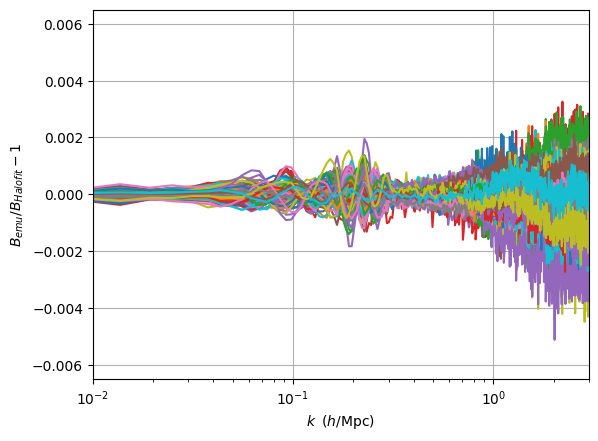

In [71]:
figure, errors = evaluate_model(mlp, test_samples, test_expqs, 0, smear=True)

In [73]:
np.savetxt("COLA_NN_errors_z0.000.txt", errors)

Number of cosmologies with error > 0.005: 0 out of 300


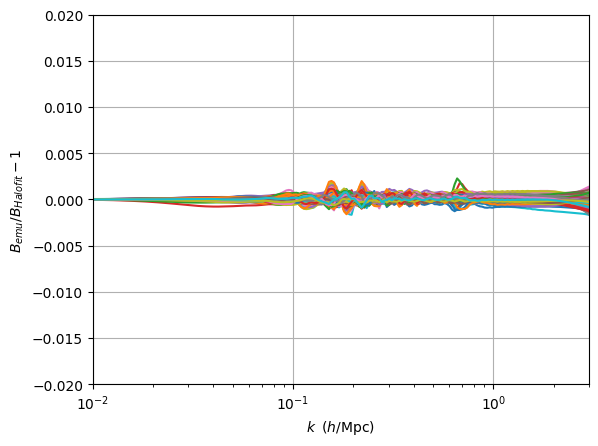

In [23]:
# Bernardo's code results
figure, errors = evaluate_model(model, test_samples, test_expqs, 0, smear=True)

In [83]:
figure.savefig("11pcs_norm2.pdf")

Number of cosmologies with error > 0.005: 8 out of 300


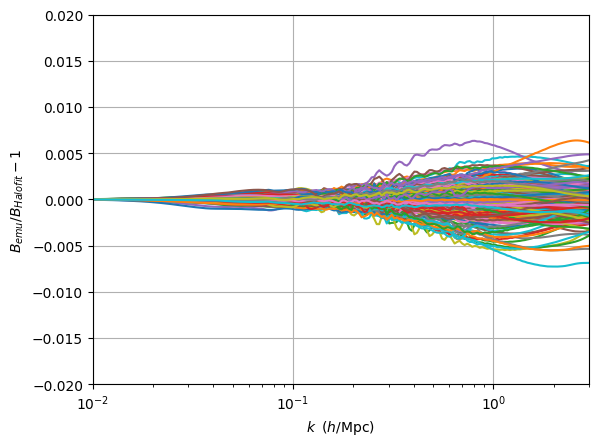

In [35]:
# PC Normalization 2
figure, errors = evaluate_model(resnet, test_samples, test_expqs, 0, smear=True)

Number of cosmologies with error > 0.005: 12 out of 300


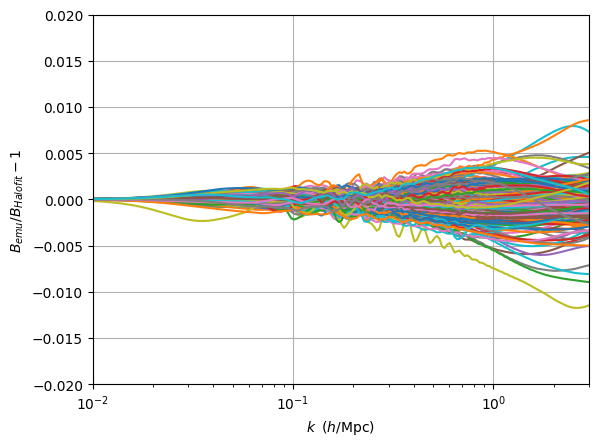

In [19]:
resnet = keras.models.load_model(f"models/wcdm/resnet_smear_stretch10_11PCS")
figure, errors = evaluate_model(resnet, test_samples, test_expqs, 0, smear=True)

In [43]:
figure.suptitle("wCDM Emulation Errors (15PCS)")
figure.savefig("plots/errors_wcdm_15pcs.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 18 out of 300


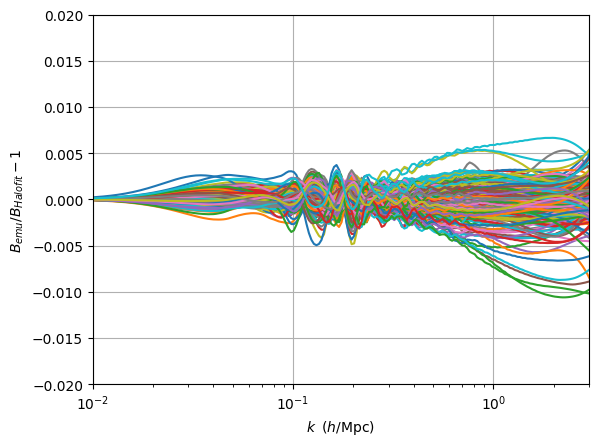

In [30]:
resnet = keras.models.load_model(f"models/wcdm/RESNET_Z0.00_{len(train_samples)}")
figure2, errors2 = evaluate_model(resnet, test_samples, test_expqs, 0, smear=True)

Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 1 out of 300


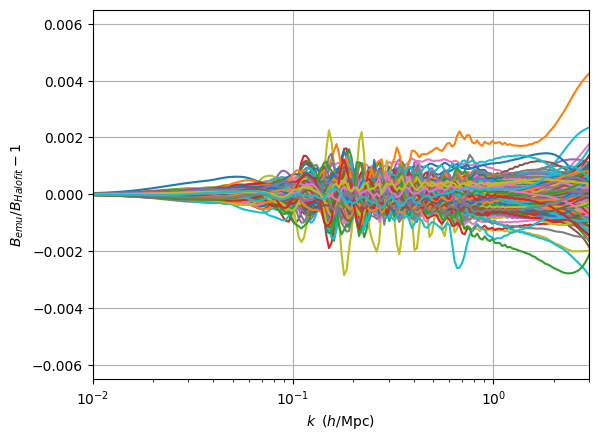

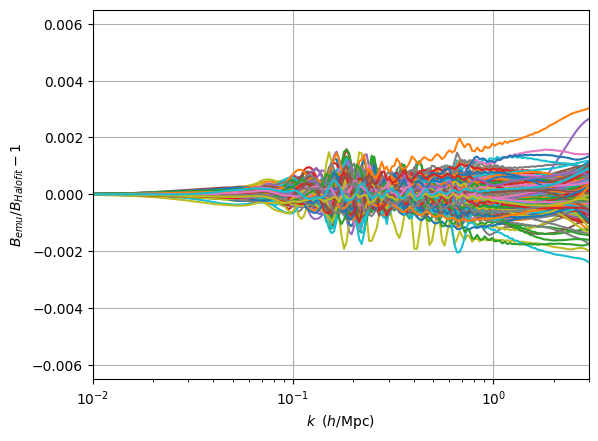

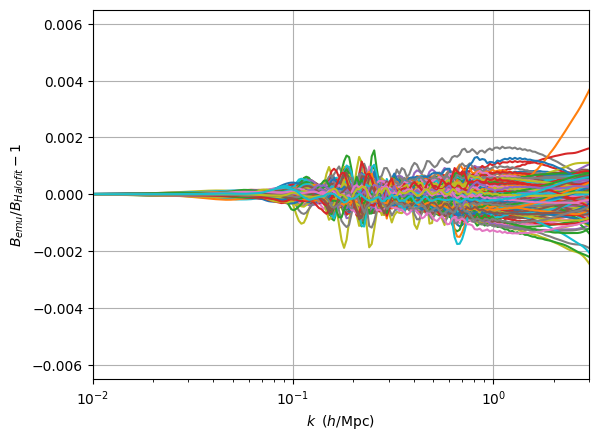

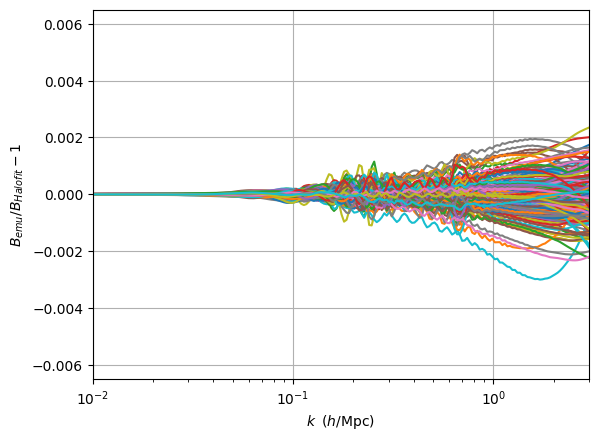

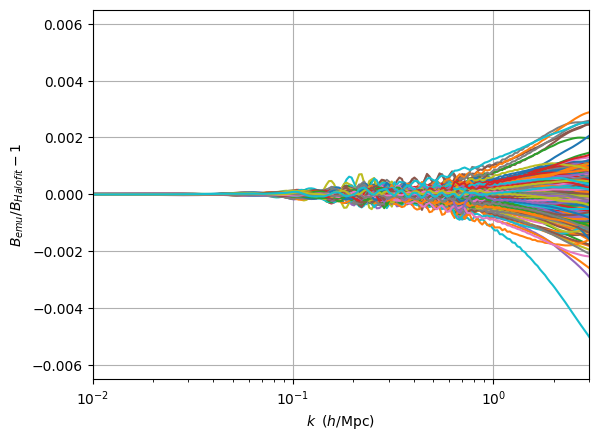

In [19]:
for i, z in enumerate(redshifts):
    resnet = keras.models.load_model(f"models/wcdm/MLP_Z{z:.2f}_{len(train_samples)}")
    figure, errors = evaluate_model(resnet, test_samples, test_expqs, i, smear=True)
    np.savetxt(f"errors/errors_halofit{len(train_samples)}_nn_z={z:.1f}.txt", errors)

Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 0 out of 300
Number of cosmologies with error > 0.005: 0 out of 300


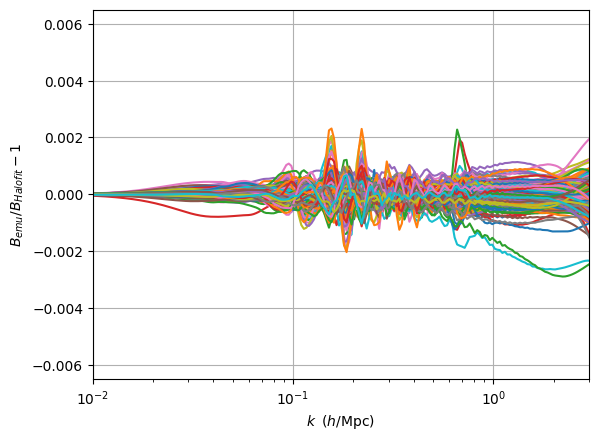

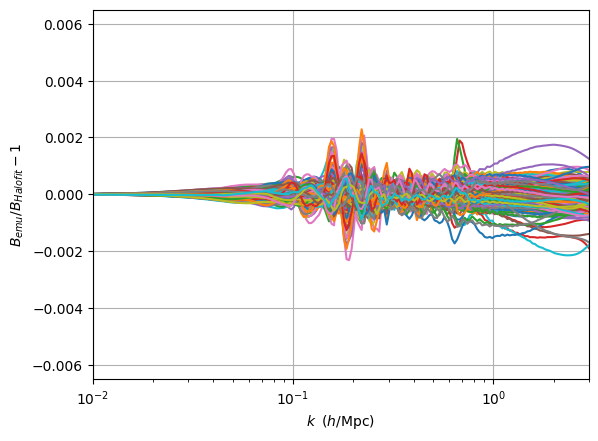

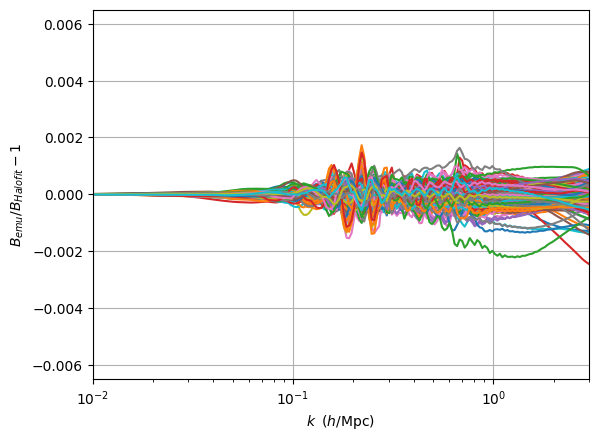

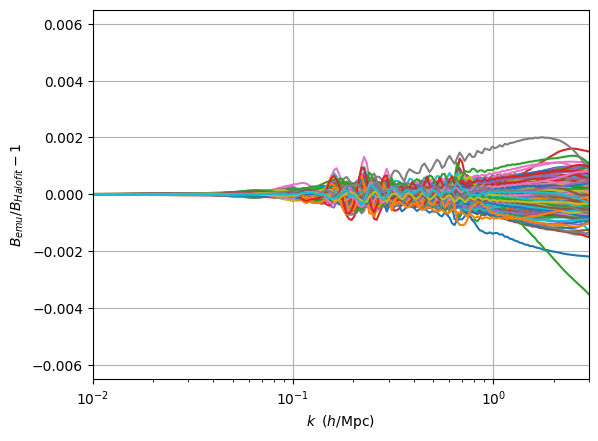

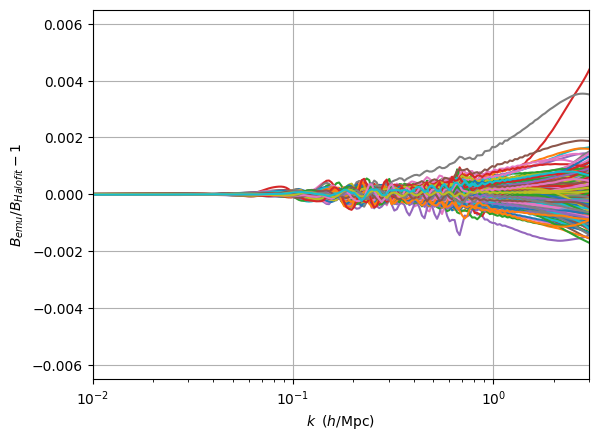

In [23]:
for i, z in enumerate(redshifts):
    mlp = keras.models.load_model(f"models/lcdm/MLP_Z{z:.2f}_{len(train_samples)}")
    figure, errors = evaluate_model(mlp, test_samples, test_expqs, i, smear=True)
    np.savetxt(f"errors/errors_halofit{len(train_samples)}_nn_z={z:.1f}.txt", errors)

Number of cosmologies with error > 0.005: 8 out of 300


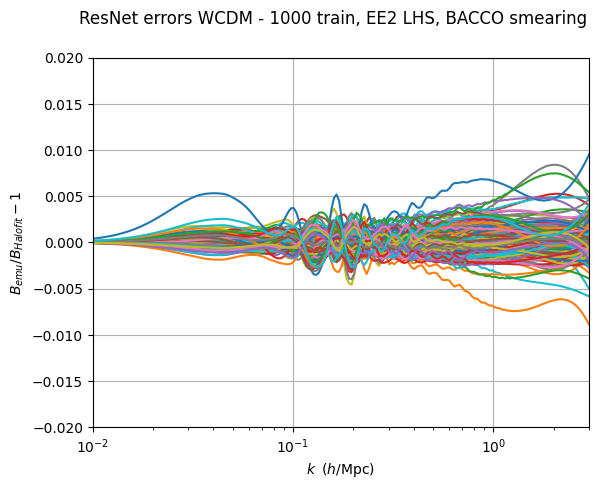

In [78]:
resnet_smeared = keras.models.load_model("models/wcdm/resnet_smear_stretch10_1kpts")
figure, errors = evaluate_model(resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle(f"ResNet errors {model.upper()} - {len(train_samples)} train, EE2 LHS, BACCO smearing")
figure.savefig("plots/resnet_smeared_errors_wcdm_stretch10_1kpts.pdf", bbox_inches="tight")

In [83]:
np.amax(np.abs(errors))

0.010367110335961272

Number of cosmologies with error > 0.005: 8 out of 300


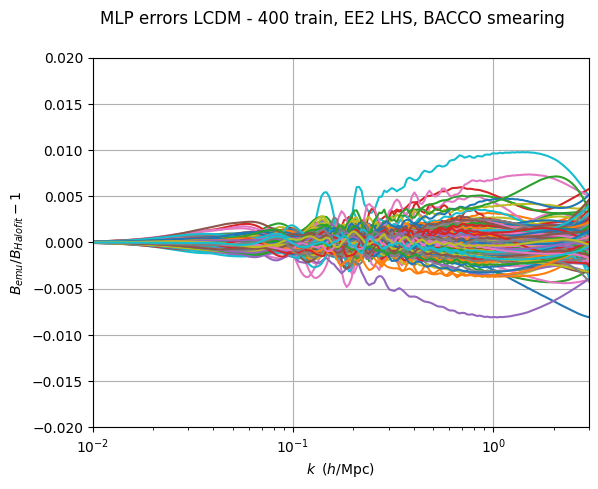

In [70]:
mlp_smeared = keras.models.load_model("models/mlp_smear")
figure = evaluate_model(mlp_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("MLP errors LCDM - 400 train, EE2 LHS, BACCO smearing")
figure.savefig("plots/mlp_smeared_errors.pdf", bbox_inches="tight")

Cosmology 9 in test sample is weird
Number of cosmologies with error > 0.005: 4 out of 300


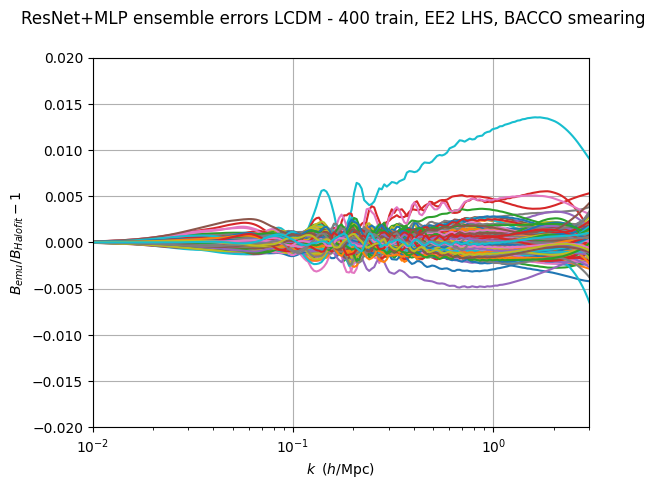

In [71]:
resnet_smeared = keras.models.load_model("models/resnet_smear")
figure = evaluate_ensemble(mlp_smeared, resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, EE2 LHS, BACCO smearing")
figure.savefig("plots/ensemble_errors.pdf", bbox_inches="tight")

Cosmology 252 in test sample is weird
Number of cosmologies with error > 0.005: 1 out of 300


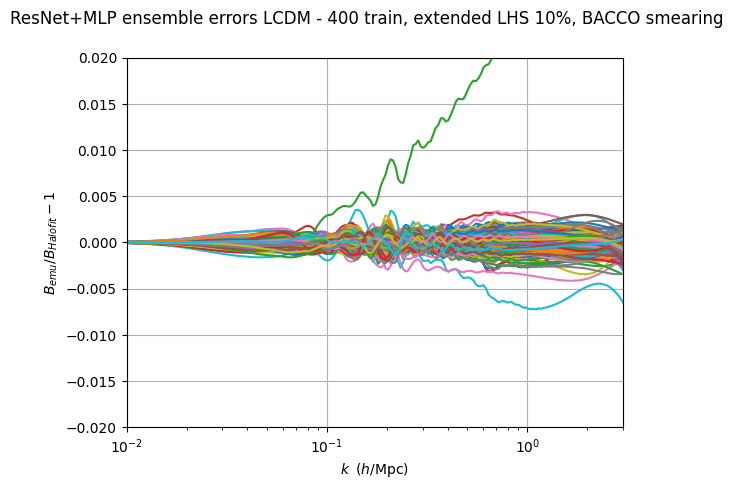

In [36]:
figure = evaluate_ensemble(mlp_smeared_stretch10, resnet_smeared_stretch10, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, extended LHS 10%, BACCO smearing")
figure.savefig("plots/ensemble.pdf", bbox_inches="tight")

Cosmology 252 in test sample is weird
Number of cosmologies with error > 0.005: 3 out of 300


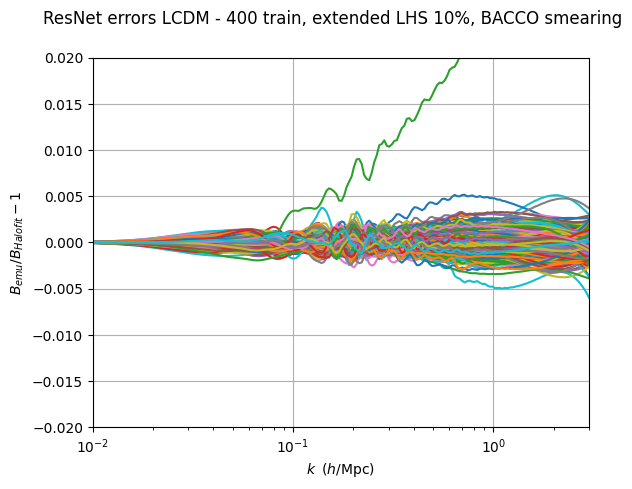

In [32]:
resnet_smeared_stretch10 = keras.models.load_model("models/resnet_smear_stretch10")
figure = evaluate_model(resnet_smeared_stretch10, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors LCDM - 400 train, extended LHS 10%, BACCO smearing")
figure.savefig("plots/resnet_smeared_errors_stretchLHS10.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 0 out of 300


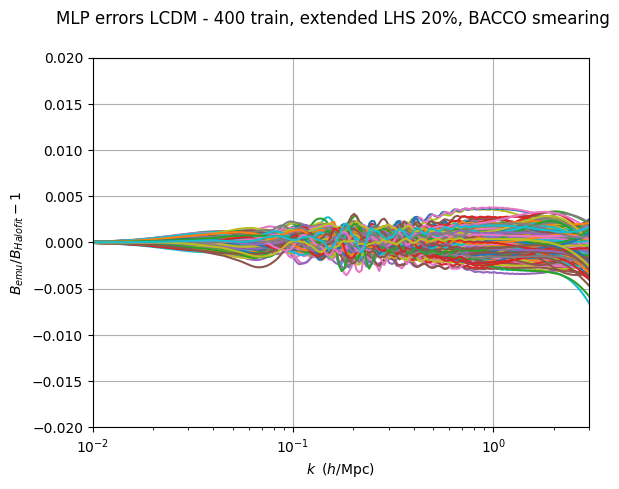

In [52]:
mlp_smeared_stretch20 = keras.models.load_model("models/mlp_smear_stretch20")
figure = evaluate_model(mlp_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("MLP errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("plots/mlp_smeared_errors_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 1 out of 300


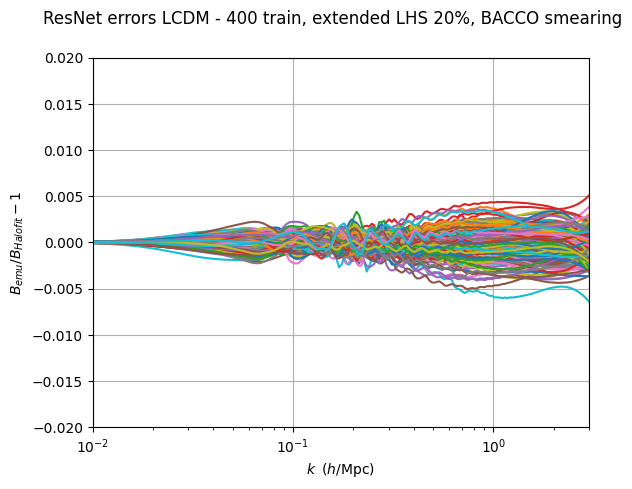

In [53]:
resnet_smeared_stretch20 = keras.models.load_model("models/resnet_smear_stretch20")
figure = evaluate_model(resnet_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("resnet_smeared_errors_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 0 out of 300


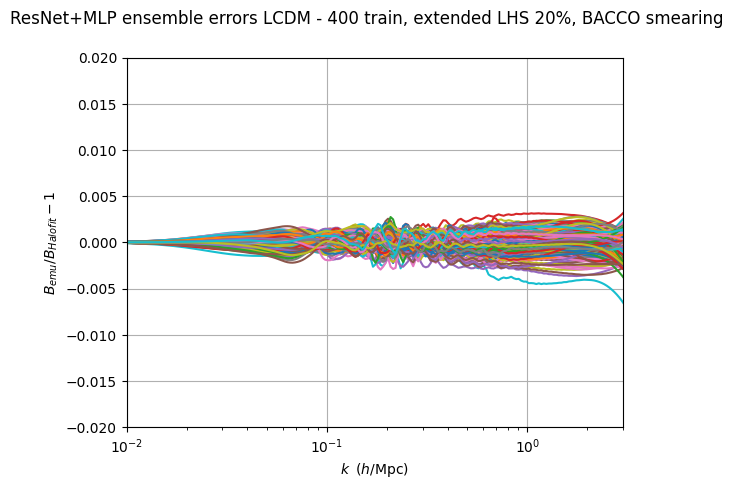

In [54]:
figure = evaluate_ensemble(resnet_smeared_stretch20, mlp_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("ensemble_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 4 out of 300


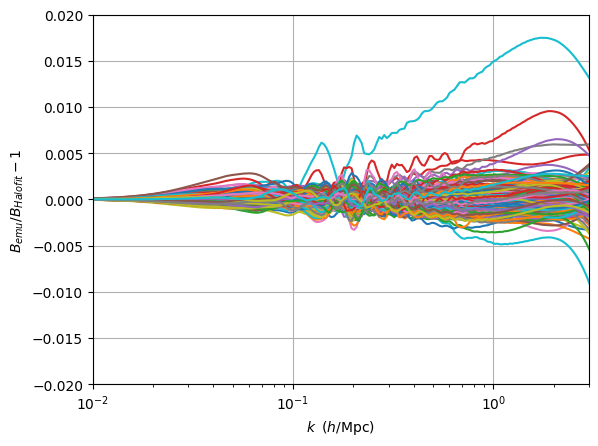

In [65]:
resnet_smeared = keras.models.load_model("models/resnet_smear")
figure = evaluate_model(resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors - 400 train, BACCO smearing")
figure.savefig("resnet_smeared_errors.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 23 out of 300


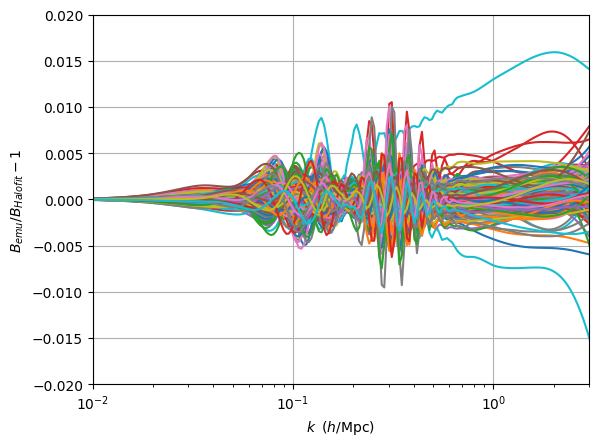

In [74]:
resnet_no_smear = keras.models.load_model("models/resnet_nosmear")
figure = evaluate_model(resnet_no_smear, test_samples, test_boosts, 0, smear=False)
figure.suptitle("ResNet errors - 400 train, no smearing")
figure.savefig("resnet_nosmear_errors.pdf", bbox_inches="tight")